# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [4]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [ ]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [ ]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [ ]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [ ]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss_with_reg, loss)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [ ]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

# Допишем код для процесса тренировки

In [ ]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-5)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), num_epochs=20, batch_size=20, learning_rate=1e-1, learning_rate_decay=1.0)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down and train and val accuracy go up for every epoch
loss_history, train_history, val_history = trainer.fit()

In [ ]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [ ]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-5)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

In [ ]:
plt.plot(train_history)
plt.plot(val_history)

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [ ]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-5)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [ ]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [ ]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=2*1e-2, learning_rate_decay=1.0, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **40%** на validation set.

In [7]:
# Let's train the best one-hidden-layer network we can
from multiprocessing import Pool

learning_rates = [1e-1, 1e-2, 1e-3]
reg_strengths = [1e-3, 1e-4, 1e-5, 1e-6]
learning_rate_decays = [1.0, 0.999, 0.99]
hidden_layer_sizes = range(50, 201, 50)
num_epochs = [20]
batch_sizes = range(50, 201, 50)
optimizers = [SGD, MomentumSGD]

best_classifier = None
best_val_accuracy = 0.0

loss_history = []
train_history = []
val_history = []

import itertools

it = itertools.product(
    learning_rates,
    reg_strengths,
    learning_rate_decays,
    hidden_layer_sizes,
    num_epochs,
    batch_sizes,
    optimizers
)

dataset = Dataset(train_X, train_y, val_X, val_y)

def fit_predict(learning_rate, reg_strength, learning_rate_decay, hidden_layer_size, num_epoch, batch_size, optimizer):
    model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = reg_strength)
    trainer = Trainer(model, dataset, optimizer(), learning_rate=learning_rate, learning_rate_decay=learning_rate_decay, num_epochs=num_epoch, batch_size=batch_size)
    return trainer, trainer.fit()

with Pool() as pool:
    trainers = pool.starmap(fit_predict, it)
    
for trainer, (l, t, v) in trainers:
    if v[-1] > best_val_accuracy:
        best_classifier = trainer.model
        loss_history, train_history, val_history = l, t, v
        best_val_accuracy = v[-1]

print('best validation accuracy achieved: %f' % best_val_accuracy)

0: Loss: 2.243988, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.220458, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.235429, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.268060, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.176139, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.174683, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.224181, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.159515, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.205356, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.227427, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.262119, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.320570, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.262159, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.254622, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.253544, Train accuracy: 0.196667, val

7: Loss: 1.310681, Train accuracy: 0.704222, val accuracy: 0.681000
18: Loss: 1.409697, Train accuracy: 0.519778, val accuracy: 0.514000
10: Loss: 1.457533, Train accuracy: 0.666000, val accuracy: 0.650000
14: Loss: 1.591137, Train accuracy: 0.442556, val accuracy: 0.442000
12: Loss: 1.479174, Train accuracy: 0.675333, val accuracy: 0.673000
2: Loss: 1.439849, Train accuracy: 0.480556, val accuracy: 0.482000
8: Loss: 1.367844, Train accuracy: 0.682333, val accuracy: 0.656000
9: Loss: 1.187408, Train accuracy: 0.648778, val accuracy: 0.650000
19: Loss: 1.392728, Train accuracy: 0.532778, val accuracy: 0.525000
3: Loss: 1.391585, Train accuracy: 0.556667, val accuracy: 0.558000
8: Loss: 1.282083, Train accuracy: 0.665000, val accuracy: 0.658000
9: Loss: 1.162257, Train accuracy: 0.697222, val accuracy: 0.675000
15: Loss: 1.581572, Train accuracy: 0.488000, val accuracy: 0.484000
13: Loss: 1.214911, Train accuracy: 0.705111, val accuracy: 0.675000
11: Loss: 1.278364, Train accuracy: 0.651

4: Loss: 1.773108, Train accuracy: 0.618444, val accuracy: 0.618000
15: Loss: 1.936000, Train accuracy: 0.279333, val accuracy: 0.276000
15: Loss: 0.691753, Train accuracy: 0.849889, val accuracy: 0.722000
3: Loss: 2.237700, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 1.981681, Train accuracy: 0.301889, val accuracy: 0.306000
4: Loss: 2.248318, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 0.871165, Train accuracy: 0.755333, val accuracy: 0.704000
1: Loss: 2.488375, Train accuracy: 0.412667, val accuracy: 0.409000
18: Loss: 0.709970, Train accuracy: 0.778111, val accuracy: 0.711000
17: Loss: 1.941426, Train accuracy: 0.328889, val accuracy: 0.330000
16: Loss: 0.627276, Train accuracy: 0.828111, val accuracy: 0.707000
16: Loss: 0.719481, Train accuracy: 0.770000, val accuracy: 0.726000
5: Loss: 1.575503, Train accuracy: 0.616222, val accuracy: 0.600000
18: Loss: 1.859956, Train accuracy: 0.353333, val accuracy: 0.356000
5: Loss: 2.249201, Train accuracy: 0.196

10: Loss: 1.862786, Train accuracy: 0.590778, val accuracy: 0.546000
6: Loss: 1.528784, Train accuracy: 0.632667, val accuracy: 0.607000
7: Loss: 0.929540, Train accuracy: 0.687556, val accuracy: 0.661000
1: Loss: 2.276581, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.001602, Train accuracy: 0.275778, val accuracy: 0.271000
16: Loss: 2.023931, Train accuracy: 0.597667, val accuracy: 0.595000
2: Loss: 2.241281, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 1.064535, Train accuracy: 0.718667, val accuracy: 0.669000
15: Loss: 1.869294, Train accuracy: 0.300000, val accuracy: 0.306000
11: Loss: 1.539498, Train accuracy: 0.632667, val accuracy: 0.621000
9: Loss: 0.851202, Train accuracy: 0.741889, val accuracy: 0.705000
3: Loss: 2.211751, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.160401, Train accuracy: 0.227556, val accuracy: 0.239000
4: Loss: 2.404986, Train accuracy: 0.619222, val accuracy: 0.580000
7: Loss: 1.565012, Train accuracy: 0.635778

16: Loss: 1.353146, Train accuracy: 0.606889, val accuracy: 0.598000
3: Loss: 2.256795, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.242815, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 1.934800, Train accuracy: 0.658333, val accuracy: 0.620000
15: Loss: 0.779231, Train accuracy: 0.836556, val accuracy: 0.748000
16: Loss: 1.541270, Train accuracy: 0.747444, val accuracy: 0.678000
17: Loss: 1.423071, Train accuracy: 0.628556, val accuracy: 0.624000
4: Loss: 2.182709, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.181974, Train accuracy: 0.220000, val accuracy: 0.229000
5: Loss: 1.636444, Train accuracy: 0.489444, val accuracy: 0.479000
13: Loss: 1.582516, Train accuracy: 0.696111, val accuracy: 0.668000
16: Loss: 0.734431, Train accuracy: 0.834222, val accuracy: 0.728000
18: Loss: 1.232579, Train accuracy: 0.630778, val accuracy: 0.630000
5: Loss: 2.162434, Train accuracy: 0.231444, val accuracy: 0.232000
2: Loss: 1.854654, Train accuracy: 0.379

18: Loss: 0.557353, Train accuracy: 0.824444, val accuracy: 0.721000
10: Loss: 1.465661, Train accuracy: 0.482667, val accuracy: 0.477000
4: Loss: 2.842581, Train accuracy: 0.521000, val accuracy: 0.515000
1: Loss: 2.219485, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 1.704004, Train accuracy: 0.632889, val accuracy: 0.614000
15: Loss: 0.878728, Train accuracy: 0.743111, val accuracy: 0.708000
2: Loss: 2.220386, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 0.565654, Train accuracy: 0.857000, val accuracy: 0.731000
2: Loss: 2.234132, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 1.556802, Train accuracy: 0.508222, val accuracy: 0.505000
3: Loss: 2.242220, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 1.294237, Train accuracy: 0.646222, val accuracy: 0.637000
7: Loss: 1.651431, Train accuracy: 0.580556, val accuracy: 0.566000
5: Loss: 2.033357, Train accuracy: 0.579000, val accuracy: 0.583000
4: Loss: 2.256445, Train accuracy: 0.196667

15: Loss: 1.564325, Train accuracy: 0.631778, val accuracy: 0.638000
1: Loss: 2.236080, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 1.279827, Train accuracy: 0.709333, val accuracy: 0.663000
15: Loss: 1.183160, Train accuracy: 0.631111, val accuracy: 0.632000
12: Loss: 1.332294, Train accuracy: 0.691111, val accuracy: 0.657000
15: Loss: 0.757466, Train accuracy: 0.755000, val accuracy: 0.725000
2: Loss: 2.248923, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 1.087321, Train accuracy: 0.683111, val accuracy: 0.646000
12: Loss: 1.215572, Train accuracy: 0.739556, val accuracy: 0.698000
5: Loss: 1.590544, Train accuracy: 0.612111, val accuracy: 0.564000
13: Loss: 1.278093, Train accuracy: 0.727222, val accuracy: 0.685000
3: Loss: 2.227035, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.062985, Train accuracy: 0.540111, val accuracy: 0.496000
16: Loss: 1.054162, Train accuracy: 0.664222, val accuracy: 0.654000
13: Loss: 1.297559, Train accuracy: 0.6

2: Loss: 1.761786, Train accuracy: 0.442889, val accuracy: 0.433000
13: Loss: 1.143080, Train accuracy: 0.711111, val accuracy: 0.638000
1: Loss: 2.204395, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 1.080100, Train accuracy: 0.701111, val accuracy: 0.634000
10: Loss: 1.724539, Train accuracy: 0.440556, val accuracy: 0.422000
3: Loss: 1.356117, Train accuracy: 0.576222, val accuracy: 0.603000
0: Loss: 2.273294, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 1.833212, Train accuracy: 0.318889, val accuracy: 0.327000
3: Loss: 1.269286, Train accuracy: 0.604333, val accuracy: 0.579000
3: Loss: 1.717047, Train accuracy: 0.498667, val accuracy: 0.490000
4: Loss: 1.192221, Train accuracy: 0.626667, val accuracy: 0.593000
4: Loss: 1.206839, Train accuracy: 0.610667, val accuracy: 0.594000
11: Loss: 1.613187, Train accuracy: 0.492000, val accuracy: 0.487000
1: Loss: 2.222151, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 1.574130, Train accuracy: 0.558889, 

10: Loss: 1.588030, Train accuracy: 0.687778, val accuracy: 0.616000
17: Loss: 1.459034, Train accuracy: 0.516111, val accuracy: 0.503000
15: Loss: 0.638303, Train accuracy: 0.722111, val accuracy: 0.656000
4: Loss: 2.244623, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.127001, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 1.426420, Train accuracy: 0.673000, val accuracy: 0.638000
19: Loss: 0.739780, Train accuracy: 0.809000, val accuracy: 0.698000
4: Loss: 1.873532, Train accuracy: 0.389444, val accuracy: 0.387000
5: Loss: 2.264410, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.351200, Train accuracy: 0.534556, val accuracy: 0.515000
8: Loss: 1.510427, Train accuracy: 0.721000, val accuracy: 0.681000
5: Loss: 2.015057, Train accuracy: 0.245667, val accuracy: 0.243000
6: Loss: 2.229319, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 0.706535, Train accuracy: 0.752889, val accuracy: 0.670000
0: Loss: 2.230176, Train accuracy: 0.19666

14: Loss: 1.138589, Train accuracy: 0.713333, val accuracy: 0.697000
4: Loss: 2.179439, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 1.303999, Train accuracy: 0.515778, val accuracy: 0.510000
7: Loss: 1.252990, Train accuracy: 0.667667, val accuracy: 0.646000
14: Loss: 0.935979, Train accuracy: 0.829778, val accuracy: 0.726000
18: Loss: 1.297339, Train accuracy: 0.673778, val accuracy: 0.661000
12: Loss: 1.704981, Train accuracy: 0.386111, val accuracy: 0.380000
14: Loss: 1.220822, Train accuracy: 0.542667, val accuracy: 0.540000
5: Loss: 2.218664, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 1.238801, Train accuracy: 0.692889, val accuracy: 0.679000
18: Loss: 1.015261, Train accuracy: 0.782889, val accuracy: 0.685000
15: Loss: 0.535896, Train accuracy: 0.842444, val accuracy: 0.726000
15: Loss: 0.803400, Train accuracy: 0.735556, val accuracy: 0.690000
15: Loss: 1.355526, Train accuracy: 0.571333, val accuracy: 0.564000
6: Loss: 2.179049, Train accuracy: 0.1

8: Loss: 1.823552, Train accuracy: 0.375222, val accuracy: 0.369000
4: Loss: 1.220744, Train accuracy: 0.634111, val accuracy: 0.620000
4: Loss: 1.844871, Train accuracy: 0.558111, val accuracy: 0.551000
11: Loss: 0.872276, Train accuracy: 0.785444, val accuracy: 0.703000
11: Loss: 2.141953, Train accuracy: 0.243111, val accuracy: 0.248000
3: Loss: 1.868957, Train accuracy: 0.297556, val accuracy: 0.308000
14: Loss: 0.757788, Train accuracy: 0.773889, val accuracy: 0.704000
5: Loss: 1.122346, Train accuracy: 0.688778, val accuracy: 0.669000
5: Loss: 1.333509, Train accuracy: 0.658000, val accuracy: 0.645000
12: Loss: 2.076208, Train accuracy: 0.262111, val accuracy: 0.259000
9: Loss: 1.619632, Train accuracy: 0.426444, val accuracy: 0.434000
15: Loss: 0.762453, Train accuracy: 0.802778, val accuracy: 0.724000
12: Loss: 0.906940, Train accuracy: 0.769000, val accuracy: 0.681000
5: Loss: 1.994617, Train accuracy: 0.580889, val accuracy: 0.557000
6: Loss: 1.282066, Train accuracy: 0.67833

17: Loss: 0.665270, Train accuracy: 0.845444, val accuracy: 0.743000
4: Loss: 2.244938, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.622235, Train accuracy: 0.426333, val accuracy: 0.413000
14: Loss: 2.386050, Train accuracy: 0.590111, val accuracy: 0.563000
5: Loss: 2.240249, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 0.905365, Train accuracy: 0.747333, val accuracy: 0.706000
0: Loss: 2.135315, Train accuracy: 0.197333, val accuracy: 0.207000
6: Loss: 2.212613, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 1.669650, Train accuracy: 0.439000, val accuracy: 0.440000
18: Loss: 0.545094, Train accuracy: 0.872444, val accuracy: 0.751000
12: Loss: 1.053730, Train accuracy: 0.701889, val accuracy: 0.701000
6: Loss: 2.176281, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 0.807163, Train accuracy: 0.739556, val accuracy: 0.687000
0: Loss: 2.205877, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.171327, Train accuracy: 0.2181

1: Loss: 1.909617, Train accuracy: 0.310889, val accuracy: 0.325000
2: Loss: 2.239078, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.018059, Train accuracy: 0.270000, val accuracy: 0.274000
6: Loss: 1.258149, Train accuracy: 0.667889, val accuracy: 0.630000
12: Loss: 2.051327, Train accuracy: 0.270333, val accuracy: 0.268000
3: Loss: 2.232831, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.121115, Train accuracy: 0.248111, val accuracy: 0.254000
7: Loss: 1.294897, Train accuracy: 0.713889, val accuracy: 0.687000
2: Loss: 1.663774, Train accuracy: 0.422444, val accuracy: 0.425000
7: Loss: 1.925046, Train accuracy: 0.314111, val accuracy: 0.316000
11: Loss: 0.936268, Train accuracy: 0.772444, val accuracy: 0.685000
0: Loss: 1.896594, Train accuracy: 0.336000, val accuracy: 0.331000
4: Loss: 2.215664, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.008240, Train accuracy: 0.290111, val accuracy: 0.295000
8: Loss: 1.020661, Train accuracy: 0.697000, 

2: Loss: 1.664976, Train accuracy: 0.575667, val accuracy: 0.563000
7: Loss: 1.050629, Train accuracy: 0.721111, val accuracy: 0.676000
10: Loss: 0.926066, Train accuracy: 0.716889, val accuracy: 0.682000
2: Loss: 2.226334, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 0.782840, Train accuracy: 0.756444, val accuracy: 0.719000
8: Loss: 1.714869, Train accuracy: 0.610556, val accuracy: 0.580000
18: Loss: 0.713077, Train accuracy: 0.849889, val accuracy: 0.713000
3: Loss: 1.437901, Train accuracy: 0.626778, val accuracy: 0.593000
8: Loss: 0.944962, Train accuracy: 0.699000, val accuracy: 0.670000
3: Loss: 2.115405, Train accuracy: 0.298000, val accuracy: 0.297000
12: Loss: 0.702072, Train accuracy: 0.757111, val accuracy: 0.703000
3: Loss: 2.197210, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 1.063329, Train accuracy: 0.680778, val accuracy: 0.667000
13: Loss: 0.771063, Train accuracy: 0.774889, val accuracy: 0.719000
19: Loss: 0.537574, Train accuracy: 0.8320

18: Loss: 1.568659, Train accuracy: 0.432556, val accuracy: 0.430000
17: Loss: 1.452566, Train accuracy: 0.503444, val accuracy: 0.492000
8: Loss: 0.984456, Train accuracy: 0.649000, val accuracy: 0.651000
2: Loss: 2.240656, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 1.026768, Train accuracy: 0.727111, val accuracy: 0.702000
18: Loss: 2.281869, Train accuracy: 0.585889, val accuracy: 0.555000
19: Loss: 1.584729, Train accuracy: 0.451444, val accuracy: 0.452000
3: Loss: 2.253767, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.429181, Train accuracy: 0.531889, val accuracy: 0.522000
5: Loss: 1.924203, Train accuracy: 0.446889, val accuracy: 0.430000
9: Loss: 0.962406, Train accuracy: 0.671556, val accuracy: 0.671000
19: Loss: 0.940937, Train accuracy: 0.797222, val accuracy: 0.725000
0: Loss: 2.243810, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.257870, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 1.380718, Train accuracy: 0.552

12: Loss: 0.796325, Train accuracy: 0.821444, val accuracy: 0.742000
19: Loss: 0.662513, Train accuracy: 0.834889, val accuracy: 0.735000
3: Loss: 2.158688, Train accuracy: 0.544778, val accuracy: 0.527000
13: Loss: 1.504828, Train accuracy: 0.548778, val accuracy: 0.548000
7: Loss: 1.884464, Train accuracy: 0.687444, val accuracy: 0.637000
6: Loss: 1.239514, Train accuracy: 0.693889, val accuracy: 0.661000
19: Loss: 0.778814, Train accuracy: 0.765889, val accuracy: 0.709000
13: Loss: 0.833186, Train accuracy: 0.812111, val accuracy: 0.731000
1: Loss: 2.946408, Train accuracy: 0.444000, val accuracy: 0.437000
7: Loss: 1.178620, Train accuracy: 0.683556, val accuracy: 0.648000
14: Loss: 1.435614, Train accuracy: 0.569889, val accuracy: 0.565000
0: Loss: 2.217405, Train accuracy: 0.318889, val accuracy: 0.332000
8: Loss: 1.051230, Train accuracy: 0.700889, val accuracy: 0.655000
4: Loss: 2.585081, Train accuracy: 0.559222, val accuracy: 0.538000
14: Loss: 0.641947, Train accuracy: 0.8225

16: Loss: 1.381371, Train accuracy: 0.720778, val accuracy: 0.643000
13: Loss: 0.977318, Train accuracy: 0.725333, val accuracy: 0.653000
14: Loss: 1.528584, Train accuracy: 0.709778, val accuracy: 0.635000
13: Loss: 2.045538, Train accuracy: 0.275000, val accuracy: 0.275000
10: Loss: 1.231291, Train accuracy: 0.716889, val accuracy: 0.652000
14: Loss: 1.438782, Train accuracy: 0.624111, val accuracy: 0.605000
11: Loss: 2.109865, Train accuracy: 0.236556, val accuracy: 0.242000
9: Loss: 1.078633, Train accuracy: 0.676667, val accuracy: 0.655000
14: Loss: 1.967299, Train accuracy: 0.279556, val accuracy: 0.280000
15: Loss: 1.037750, Train accuracy: 0.709667, val accuracy: 0.626000
14: Loss: 0.946188, Train accuracy: 0.729889, val accuracy: 0.644000
11: Loss: 1.252016, Train accuracy: 0.751889, val accuracy: 0.686000
15: Loss: 1.954388, Train accuracy: 0.308000, val accuracy: 0.313000
12: Loss: 2.054861, Train accuracy: 0.256444, val accuracy: 0.260000
17: Loss: 1.973238, Train accuracy:

17: Loss: 0.958037, Train accuracy: 0.780556, val accuracy: 0.724000
5: Loss: 2.189747, Train accuracy: 0.239667, val accuracy: 0.245000
7: Loss: 1.975824, Train accuracy: 0.306222, val accuracy: 0.311000
7: Loss: 2.030425, Train accuracy: 0.357111, val accuracy: 0.352000
7: Loss: 1.014012, Train accuracy: 0.675222, val accuracy: 0.639000
17: Loss: 1.067078, Train accuracy: 0.762889, val accuracy: 0.716000
18: Loss: 0.983798, Train accuracy: 0.798111, val accuracy: 0.726000
14: Loss: 1.269130, Train accuracy: 0.569556, val accuracy: 0.558000
6: Loss: 2.189804, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 1.906728, Train accuracy: 0.362778, val accuracy: 0.352000
6: Loss: 1.971273, Train accuracy: 0.275444, val accuracy: 0.280000
19: Loss: 1.055708, Train accuracy: 0.796667, val accuracy: 0.727000
15: Loss: 1.259766, Train accuracy: 0.596000, val accuracy: 0.583000
8: Loss: 0.927502, Train accuracy: 0.738333, val accuracy: 0.713000
7: Loss: 2.223398, Train accuracy: 0.19666

3: Loss: 1.242192, Train accuracy: 0.601778, val accuracy: 0.587000
16: Loss: 0.619478, Train accuracy: 0.805333, val accuracy: 0.712000
5: Loss: 1.037228, Train accuracy: 0.702333, val accuracy: 0.673000
0: Loss: 2.149657, Train accuracy: 0.198111, val accuracy: 0.207000
8: Loss: 1.573498, Train accuracy: 0.603778, val accuracy: 0.590000
5: Loss: 1.576977, Train accuracy: 0.618333, val accuracy: 0.592000
17: Loss: 0.870023, Train accuracy: 0.785778, val accuracy: 0.690000
4: Loss: 1.370629, Train accuracy: 0.658111, val accuracy: 0.641000
3: Loss: 2.292624, Train accuracy: 0.271111, val accuracy: 0.276000
0: Loss: 2.247710, Train accuracy: 0.224333, val accuracy: 0.226000
6: Loss: 1.114886, Train accuracy: 0.707778, val accuracy: 0.668000
1: Loss: 1.674929, Train accuracy: 0.432556, val accuracy: 0.433000
18: Loss: 0.671402, Train accuracy: 0.797333, val accuracy: 0.712000
5: Loss: 1.429688, Train accuracy: 0.681667, val accuracy: 0.661000
9: Loss: 1.292113, Train accuracy: 0.646000, 

3: Loss: 2.228520, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 0.935374, Train accuracy: 0.782333, val accuracy: 0.695000
14: Loss: 1.428137, Train accuracy: 0.707000, val accuracy: 0.662000
4: Loss: 1.132630, Train accuracy: 0.614444, val accuracy: 0.613000
1: Loss: 2.238838, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 1.282027, Train accuracy: 0.646111, val accuracy: 0.606000
4: Loss: 2.205669, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.124223, Train accuracy: 0.699000, val accuracy: 0.633000
18: Loss: 1.224149, Train accuracy: 0.724333, val accuracy: 0.701000
16: Loss: 1.116953, Train accuracy: 0.740111, val accuracy: 0.700000
15: Loss: 1.452056, Train accuracy: 0.724222, val accuracy: 0.677000
6: Loss: 1.219172, Train accuracy: 0.678000, val accuracy: 0.636000
12: Loss: 0.776689, Train accuracy: 0.789111, val accuracy: 0.702000
5: Loss: 2.236181, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.242813, Train accuracy: 0.1966

18: Loss: 1.894436, Train accuracy: 0.375667, val accuracy: 0.380000
6: Loss: 1.899202, Train accuracy: 0.532889, val accuracy: 0.510000
11: Loss: 2.096203, Train accuracy: 0.211667, val accuracy: 0.218000
3: Loss: 2.282126, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 1.125303, Train accuracy: 0.668889, val accuracy: 0.630000
4: Loss: 1.202671, Train accuracy: 0.640222, val accuracy: 0.609000
10: Loss: 2.001491, Train accuracy: 0.283556, val accuracy: 0.281000
12: Loss: 2.058728, Train accuracy: 0.244222, val accuracy: 0.248000
1: Loss: 2.213529, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 1.886104, Train accuracy: 0.402444, val accuracy: 0.409000
13: Loss: 2.036001, Train accuracy: 0.259889, val accuracy: 0.252000
5: Loss: 1.038797, Train accuracy: 0.683000, val accuracy: 0.651000
4: Loss: 2.252982, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 1.953343, Train accuracy: 0.326333, val accuracy: 0.329000
0: Loss: 2.243528, Train accuracy: 0.1966

5: Loss: 1.230811, Train accuracy: 0.690000, val accuracy: 0.656000
14: Loss: 1.490942, Train accuracy: 0.613111, val accuracy: 0.592000
18: Loss: 1.233449, Train accuracy: 0.717333, val accuracy: 0.630000
15: Loss: 1.612042, Train accuracy: 0.483222, val accuracy: 0.465000
18: Loss: 0.733827, Train accuracy: 0.788444, val accuracy: 0.692000
3: Loss: 2.231769, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 1.088000, Train accuracy: 0.761444, val accuracy: 0.697000
19: Loss: 0.736450, Train accuracy: 0.789556, val accuracy: 0.697000
6: Loss: 1.318151, Train accuracy: 0.655222, val accuracy: 0.633000
12: Loss: 1.464792, Train accuracy: 0.567000, val accuracy: 0.550000
4: Loss: 2.227319, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 1.093945, Train accuracy: 0.787444, val accuracy: 0.714000
16: Loss: 1.511864, Train accuracy: 0.516000, val accuracy: 0.509000
19: Loss: 1.697795, Train accuracy: 0.700667, val accuracy: 0.615000
5: Loss: 2.197706, Train accuracy: 0.1

5: Loss: 2.129209, Train accuracy: 0.239667, val accuracy: 0.246000
3: Loss: 1.079744, Train accuracy: 0.647556, val accuracy: 0.617000
5: Loss: 1.739806, Train accuracy: 0.492778, val accuracy: 0.490000
6: Loss: 1.091337, Train accuracy: 0.686222, val accuracy: 0.663000
19: Loss: 1.003475, Train accuracy: 0.674000, val accuracy: 0.666000
3: Loss: 2.212071, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 1.107319, Train accuracy: 0.675222, val accuracy: 0.652000
0: Loss: 2.241760, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 0.901432, Train accuracy: 0.774333, val accuracy: 0.680000
6: Loss: 2.080328, Train accuracy: 0.276778, val accuracy: 0.278000
10: Loss: 1.028144, Train accuracy: 0.687222, val accuracy: 0.673000
4: Loss: 1.194127, Train accuracy: 0.688222, val accuracy: 0.657000
8: Loss: 1.169258, Train accuracy: 0.694556, val accuracy: 0.658000
4: Loss: 2.231934, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 1.612336, Train accuracy: 0.409000, v

0: Loss: 1.821742, Train accuracy: 0.394333, val accuracy: 0.403000
1: Loss: 2.210107, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.150393, Train accuracy: 0.232444, val accuracy: 0.231000
3: Loss: 2.276574, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 1.873160, Train accuracy: 0.348111, val accuracy: 0.350000
2: Loss: 2.212181, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.205779, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.279021, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 0.816172, Train accuracy: 0.792000, val accuracy: 0.689000
4: Loss: 1.440643, Train accuracy: 0.416000, val accuracy: 0.413000
1: Loss: 1.626185, Train accuracy: 0.421556, val accuracy: 0.438000
3: Loss: 1.604077, Train accuracy: 0.509778, val accuracy: 0.518000
1: Loss: 1.133063, Train accuracy: 0.493111, val accuracy: 0.497000
14: Loss: 0.853818, Train accuracy: 0.729889, val accuracy: 0.696000
4: Loss: 2.217985, Train accuracy: 0.196667, v

9: Loss: 0.804562, Train accuracy: 0.667667, val accuracy: 0.637000
13: Loss: 0.899629, Train accuracy: 0.712111, val accuracy: 0.684000
9: Loss: 2.086036, Train accuracy: 0.275556, val accuracy: 0.277000
0: Loss: 2.279818, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 1.453079, Train accuracy: 0.652333, val accuracy: 0.582000
15: Loss: 1.191888, Train accuracy: 0.734667, val accuracy: 0.664000
10: Loss: 0.908429, Train accuracy: 0.707889, val accuracy: 0.644000
1: Loss: 2.180296, Train accuracy: 0.197111, val accuracy: 0.206000
2: Loss: 2.103365, Train accuracy: 0.469333, val accuracy: 0.474000
11: Loss: 0.950267, Train accuracy: 0.748889, val accuracy: 0.675000
10: Loss: 2.106924, Train accuracy: 0.310000, val accuracy: 0.316000
16: Loss: 1.290317, Train accuracy: 0.721556, val accuracy: 0.673000
12: Loss: 0.656438, Train accuracy: 0.729111, val accuracy: 0.676000
14: Loss: 1.004901, Train accuracy: 0.732889, val accuracy: 0.703000
12: Loss: 0.935233, Train accuracy: 0.7

3: Loss: 1.174933, Train accuracy: 0.592222, val accuracy: 0.580000
17: Loss: 0.570190, Train accuracy: 0.840667, val accuracy: 0.736000
4: Loss: 2.231951, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.207522, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 1.781526, Train accuracy: 0.398444, val accuracy: 0.395000
3: Loss: 1.273140, Train accuracy: 0.601111, val accuracy: 0.549000
10: Loss: 1.577214, Train accuracy: 0.619000, val accuracy: 0.601000
2: Loss: 1.995468, Train accuracy: 0.316556, val accuracy: 0.323000
18: Loss: 0.696226, Train accuracy: 0.839111, val accuracy: 0.730000
5: Loss: 2.137908, Train accuracy: 0.238333, val accuracy: 0.249000
4: Loss: 1.159317, Train accuracy: 0.660111, val accuracy: 0.645000
9: Loss: 1.162079, Train accuracy: 0.661556, val accuracy: 0.643000
3: Loss: 1.598278, Train accuracy: 0.452000, val accuracy: 0.464000
14: Loss: 1.674214, Train accuracy: 0.428333, val accuracy: 0.416000
4: Loss: 1.632252, Train accuracy: 0.568111

3: Loss: 1.240970, Train accuracy: 0.618111, val accuracy: 0.603000
18: Loss: 0.668831, Train accuracy: 0.856444, val accuracy: 0.735000
5: Loss: 1.824308, Train accuracy: 0.481444, val accuracy: 0.474000
12: Loss: 1.037590, Train accuracy: 0.747556, val accuracy: 0.696000
12: Loss: 1.111215, Train accuracy: 0.701444, val accuracy: 0.675000
4: Loss: 1.374337, Train accuracy: 0.643333, val accuracy: 0.621000
13: Loss: 1.204672, Train accuracy: 0.745333, val accuracy: 0.672000
19: Loss: 0.824007, Train accuracy: 0.811222, val accuracy: 0.708000
18: Loss: 1.116332, Train accuracy: 0.767667, val accuracy: 0.718000
13: Loss: 1.161504, Train accuracy: 0.737889, val accuracy: 0.672000
5: Loss: 1.237037, Train accuracy: 0.697333, val accuracy: 0.640000
19: Loss: 1.479408, Train accuracy: 0.660889, val accuracy: 0.644000
13: Loss: 1.032566, Train accuracy: 0.702889, val accuracy: 0.665000
6: Loss: 1.327534, Train accuracy: 0.520111, val accuracy: 0.520000
0: Loss: 2.260569, Train accuracy: 0.19

6: Loss: 2.707029, Train accuracy: 0.546778, val accuracy: 0.542000
12: Loss: 2.046371, Train accuracy: 0.258444, val accuracy: 0.256000
5: Loss: 2.080042, Train accuracy: 0.247222, val accuracy: 0.251000
4: Loss: 2.222463, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 1.648316, Train accuracy: 0.659000, val accuracy: 0.599000
12: Loss: 1.319867, Train accuracy: 0.528222, val accuracy: 0.512000
17: Loss: 1.681871, Train accuracy: 0.412222, val accuracy: 0.409000
13: Loss: 2.005120, Train accuracy: 0.279556, val accuracy: 0.272000
5: Loss: 2.241232, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.138948, Train accuracy: 0.269111, val accuracy: 0.268000
18: Loss: 0.825647, Train accuracy: 0.770111, val accuracy: 0.717000
14: Loss: 2.000836, Train accuracy: 0.309778, val accuracy: 0.313000
6: Loss: 2.143273, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 1.627673, Train accuracy: 0.657444, val accuracy: 0.623000
13: Loss: 1.396255, Train accuracy: 0.5664

0: Loss: 2.193587, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 1.132252, Train accuracy: 0.682222, val accuracy: 0.649000
13: Loss: 0.849648, Train accuracy: 0.793222, val accuracy: 0.728000
12: Loss: 1.125405, Train accuracy: 0.762444, val accuracy: 0.710000
0: Loss: 2.239986, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 1.091511, Train accuracy: 0.724556, val accuracy: 0.695000
5: Loss: 1.521601, Train accuracy: 0.686333, val accuracy: 0.661000
1: Loss: 2.235113, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 1.208582, Train accuracy: 0.733778, val accuracy: 0.681000
1: Loss: 1.534454, Train accuracy: 0.464444, val accuracy: 0.469000
14: Loss: 0.772921, Train accuracy: 0.804556, val accuracy: 0.709000
9: Loss: 1.316190, Train accuracy: 0.682889, val accuracy: 0.634000
8: Loss: 1.144909, Train accuracy: 0.752444, val accuracy: 0.697000
15: Loss: 1.982043, Train accuracy: 0.593111, val accuracy: 0.545000
2: Loss: 2.229585, Train accuracy: 0.196667

8: Loss: 2.210914, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 1.302400, Train accuracy: 0.633333, val accuracy: 0.620000
4: Loss: 2.172273, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.199615, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.217091, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 1.099898, Train accuracy: 0.769333, val accuracy: 0.700000
15: Loss: 0.810685, Train accuracy: 0.827333, val accuracy: 0.711000
8: Loss: 1.155105, Train accuracy: 0.615889, val accuracy: 0.607000
4: Loss: 1.318952, Train accuracy: 0.656667, val accuracy: 0.654000
10: Loss: 2.190533, Train accuracy: 0.209667, val accuracy: 0.217000
1: Loss: 2.208844, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 1.511031, Train accuracy: 0.485556, val accuracy: 0.477000
5: Loss: 1.098925, Train accuracy: 0.703111, val accuracy: 0.660000
5: Loss: 2.149327, Train accuracy: 0.233667, val accuracy: 0.237000
11: Loss: 2.177241, Train accuracy: 0.238000,

5: Loss: 2.220374, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 0.889083, Train accuracy: 0.750444, val accuracy: 0.687000
12: Loss: 0.839547, Train accuracy: 0.715111, val accuracy: 0.696000
9: Loss: 2.186351, Train accuracy: 0.266889, val accuracy: 0.267000
10: Loss: 2.044004, Train accuracy: 0.285556, val accuracy: 0.289000
6: Loss: 2.198143, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 0.959128, Train accuracy: 0.760556, val accuracy: 0.707000
17: Loss: 1.035411, Train accuracy: 0.661889, val accuracy: 0.656000
0: Loss: 2.041601, Train accuracy: 0.333444, val accuracy: 0.323000
16: Loss: 1.362958, Train accuracy: 0.644778, val accuracy: 0.645000
7: Loss: 2.127775, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 1.915156, Train accuracy: 0.313889, val accuracy: 0.314000
10: Loss: 2.017771, Train accuracy: 0.276444, val accuracy: 0.281000
13: Loss: 0.736975, Train accuracy: 0.819667, val accuracy: 0.740000
8: Loss: 2.122800, Train accuracy: 0.21

2: Loss: 1.540934, Train accuracy: 0.517222, val accuracy: 0.512000
5: Loss: 1.820877, Train accuracy: 0.485667, val accuracy: 0.482000
0: Loss: 1.830679, Train accuracy: 0.373556, val accuracy: 0.364000
7: Loss: 0.847904, Train accuracy: 0.755333, val accuracy: 0.697000
7: Loss: 1.260911, Train accuracy: 0.703556, val accuracy: 0.651000
12: Loss: 1.480046, Train accuracy: 0.658111, val accuracy: 0.583000
13: Loss: 0.783666, Train accuracy: 0.788444, val accuracy: 0.719000
14: Loss: 0.752744, Train accuracy: 0.797556, val accuracy: 0.695000
14: Loss: 1.033398, Train accuracy: 0.780333, val accuracy: 0.709000
3: Loss: 1.443947, Train accuracy: 0.579667, val accuracy: 0.603000
8: Loss: 0.886451, Train accuracy: 0.756778, val accuracy: 0.704000
15: Loss: 0.718654, Train accuracy: 0.776333, val accuracy: 0.708000
13: Loss: 1.296292, Train accuracy: 0.704111, val accuracy: 0.646000
8: Loss: 1.211509, Train accuracy: 0.720667, val accuracy: 0.677000
15: Loss: 1.100888, Train accuracy: 0.7688

18: Loss: 1.369411, Train accuracy: 0.722000, val accuracy: 0.679000
12: Loss: 1.884912, Train accuracy: 0.367556, val accuracy: 0.368000
1: Loss: 2.205575, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 1.134730, Train accuracy: 0.761222, val accuracy: 0.697000
8: Loss: 1.978498, Train accuracy: 0.337778, val accuracy: 0.340000
14: Loss: 0.828198, Train accuracy: 0.756111, val accuracy: 0.707000
4: Loss: 2.247317, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 1.772941, Train accuracy: 0.388889, val accuracy: 0.390000
2: Loss: 1.985330, Train accuracy: 0.337333, val accuracy: 0.335000
9: Loss: 1.795714, Train accuracy: 0.383889, val accuracy: 0.386000
19: Loss: 1.008441, Train accuracy: 0.789333, val accuracy: 0.714000
3: Loss: 1.583919, Train accuracy: 0.480889, val accuracy: 0.477000
14: Loss: 1.589925, Train accuracy: 0.431111, val accuracy: 0.435000
5: Loss: 2.230716, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 0.956738, Train accuracy: 0.791

0: Loss: 2.237356, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 1.538860, Train accuracy: 0.606111, val accuracy: 0.573000
9: Loss: 2.207144, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 1.009976, Train accuracy: 0.704778, val accuracy: 0.650000
12: Loss: 0.749396, Train accuracy: 0.776333, val accuracy: 0.701000
1: Loss: 2.193095, Train accuracy: 0.197556, val accuracy: 0.207000
3: Loss: 1.988562, Train accuracy: 0.287111, val accuracy: 0.288000
11: Loss: 1.876496, Train accuracy: 0.344111, val accuracy: 0.338000
9: Loss: 0.867350, Train accuracy: 0.742222, val accuracy: 0.697000
10: Loss: 2.145241, Train accuracy: 0.208667, val accuracy: 0.215000
13: Loss: 0.857172, Train accuracy: 0.787111, val accuracy: 0.712000
2: Loss: 1.727015, Train accuracy: 0.384667, val accuracy: 0.393000
15: Loss: 2.561533, Train accuracy: 0.591333, val accuracy: 0.589000
10: Loss: 1.016082, Train accuracy: 0.730556, val accuracy: 0.665000
3: Loss: 1.577998, Train accuracy: 0.57266

18: Loss: 0.434974, Train accuracy: 0.861778, val accuracy: 0.742000
11: Loss: 2.055216, Train accuracy: 0.285222, val accuracy: 0.287000
5: Loss: 1.277065, Train accuracy: 0.653111, val accuracy: 0.645000
14: Loss: 1.980649, Train accuracy: 0.280000, val accuracy: 0.284000
13: Loss: 1.040086, Train accuracy: 0.711333, val accuracy: 0.689000
19: Loss: 0.395420, Train accuracy: 0.855222, val accuracy: 0.745000
12: Loss: 1.925899, Train accuracy: 0.322667, val accuracy: 0.324000
4: Loss: 2.182699, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 1.234421, Train accuracy: 0.627889, val accuracy: 0.613000
11: Loss: 1.909827, Train accuracy: 0.690667, val accuracy: 0.607000
15: Loss: 1.990039, Train accuracy: 0.311000, val accuracy: 0.320000
6: Loss: 1.341870, Train accuracy: 0.692667, val accuracy: 0.662000
13: Loss: 1.867642, Train accuracy: 0.355444, val accuracy: 0.355000
16: Loss: 1.837380, Train accuracy: 0.352444, val accuracy: 0.345000
14: Loss: 1.653136, Train accuracy: 0.

3: Loss: 1.420352, Train accuracy: 0.600778, val accuracy: 0.564000
18: Loss: 0.801322, Train accuracy: 0.801667, val accuracy: 0.705000
18: Loss: 0.591937, Train accuracy: 0.840222, val accuracy: 0.729000
16: Loss: 1.242324, Train accuracy: 0.647556, val accuracy: 0.636000
17: Loss: 1.072327, Train accuracy: 0.801111, val accuracy: 0.742000
19: Loss: 0.660571, Train accuracy: 0.769222, val accuracy: 0.676000
7: Loss: 1.311017, Train accuracy: 0.603222, val accuracy: 0.597000
0: Loss: 2.262457, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.241610, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.275698, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 0.720940, Train accuracy: 0.827111, val accuracy: 0.717000
4: Loss: 1.776479, Train accuracy: 0.623111, val accuracy: 0.596000
1: Loss: 2.249034, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.231693, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 0.976764, Train accuracy: 0.7988

15: Loss: 0.721026, Train accuracy: 0.746000, val accuracy: 0.717000
10: Loss: 0.865454, Train accuracy: 0.723556, val accuracy: 0.689000
13: Loss: 2.094862, Train accuracy: 0.279778, val accuracy: 0.280000
15: Loss: 1.202915, Train accuracy: 0.639111, val accuracy: 0.626000
11: Loss: 0.902232, Train accuracy: 0.740778, val accuracy: 0.687000
14: Loss: 0.717459, Train accuracy: 0.719222, val accuracy: 0.682000
12: Loss: 0.914691, Train accuracy: 0.757333, val accuracy: 0.697000
15: Loss: 1.677536, Train accuracy: 0.731444, val accuracy: 0.657000
9: Loss: 1.115143, Train accuracy: 0.674444, val accuracy: 0.629000
14: Loss: 1.904673, Train accuracy: 0.306556, val accuracy: 0.308000
16: Loss: 1.319996, Train accuracy: 0.655111, val accuracy: 0.637000
13: Loss: 0.776616, Train accuracy: 0.778444, val accuracy: 0.712000
9: Loss: 1.176972, Train accuracy: 0.670889, val accuracy: 0.661000
16: Loss: 0.890889, Train accuracy: 0.756778, val accuracy: 0.709000
14: Loss: 0.793219, Train accuracy: 

19: Loss: 0.729100, Train accuracy: 0.783889, val accuracy: 0.717000
8: Loss: 1.063650, Train accuracy: 0.648111, val accuracy: 0.611000
12: Loss: 1.659415, Train accuracy: 0.515222, val accuracy: 0.510000
3: Loss: 2.235135, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 0.959986, Train accuracy: 0.683667, val accuracy: 0.666000
12: Loss: 1.103752, Train accuracy: 0.765889, val accuracy: 0.710000
12: Loss: 0.915464, Train accuracy: 0.758333, val accuracy: 0.669000
13: Loss: 1.535771, Train accuracy: 0.534667, val accuracy: 0.521000
9: Loss: 1.431135, Train accuracy: 0.681556, val accuracy: 0.638000
4: Loss: 2.220193, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 1.295339, Train accuracy: 0.642333, val accuracy: 0.604000
13: Loss: 1.047150, Train accuracy: 0.758000, val accuracy: 0.704000
0: Loss: 2.158720, Train accuracy: 0.365889, val accuracy: 0.359000
10: Loss: 1.292476, Train accuracy: 0.689889, val accuracy: 0.670000
14: Loss: 1.520968, Train accuracy: 0.578

18: Loss: 1.481406, Train accuracy: 0.551556, val accuracy: 0.540000
9: Loss: 2.041103, Train accuracy: 0.270444, val accuracy: 0.263000
7: Loss: 1.989446, Train accuracy: 0.290889, val accuracy: 0.295000
8: Loss: 1.460402, Train accuracy: 0.605222, val accuracy: 0.600000
12: Loss: 0.706715, Train accuracy: 0.771111, val accuracy: 0.687000
10: Loss: 1.928921, Train accuracy: 0.287778, val accuracy: 0.287000
19: Loss: 1.351723, Train accuracy: 0.563222, val accuracy: 0.562000
8: Loss: 1.897567, Train accuracy: 0.352111, val accuracy: 0.357000
2: Loss: 1.619234, Train accuracy: 0.516889, val accuracy: 0.503000
10: Loss: 2.511979, Train accuracy: 0.699778, val accuracy: 0.671000
13: Loss: 0.756891, Train accuracy: 0.794333, val accuracy: 0.708000
9: Loss: 1.246255, Train accuracy: 0.625333, val accuracy: 0.625000
9: Loss: 1.695401, Train accuracy: 0.399556, val accuracy: 0.402000
11: Loss: 1.884543, Train accuracy: 0.337111, val accuracy: 0.331000
14: Loss: 1.353829, Train accuracy: 0.735

12: Loss: 1.199238, Train accuracy: 0.773111, val accuracy: 0.690000
1: Loss: 2.082634, Train accuracy: 0.454778, val accuracy: 0.440000
19: Loss: 1.062238, Train accuracy: 0.728000, val accuracy: 0.640000
11: Loss: 1.072776, Train accuracy: 0.744667, val accuracy: 0.662000
13: Loss: 1.108858, Train accuracy: 0.687889, val accuracy: 0.641000
13: Loss: 1.809692, Train accuracy: 0.365889, val accuracy: 0.370000
3: Loss: 2.237741, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 0.952197, Train accuracy: 0.734222, val accuracy: 0.664000
13: Loss: 1.233783, Train accuracy: 0.741667, val accuracy: 0.682000
12: Loss: 0.907323, Train accuracy: 0.747333, val accuracy: 0.682000
2: Loss: 2.244746, Train accuracy: 0.552889, val accuracy: 0.521000
14: Loss: 1.712600, Train accuracy: 0.400667, val accuracy: 0.390000
0: Loss: 2.212426, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 1.037486, Train accuracy: 0.763667, val accuracy: 0.711000
13: Loss: 0.771513, Train accuracy: 0.76

12: Loss: 1.339404, Train accuracy: 0.549556, val accuracy: 0.551000
14: Loss: 1.797826, Train accuracy: 0.365556, val accuracy: 0.363000
5: Loss: 2.128702, Train accuracy: 0.238667, val accuracy: 0.241000
13: Loss: 1.545019, Train accuracy: 0.655778, val accuracy: 0.619000
14: Loss: 1.186177, Train accuracy: 0.589333, val accuracy: 0.578000
12: Loss: 0.650683, Train accuracy: 0.813444, val accuracy: 0.732000
6: Loss: 2.209904, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 1.755078, Train accuracy: 0.384111, val accuracy: 0.370000
4: Loss: 2.256325, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.126686, Train accuracy: 0.263778, val accuracy: 0.262000
13: Loss: 1.069811, Train accuracy: 0.803889, val accuracy: 0.726000
13: Loss: 1.512012, Train accuracy: 0.567333, val accuracy: 0.562000
16: Loss: 1.723315, Train accuracy: 0.409000, val accuracy: 0.400000
14: Loss: 1.586376, Train accuracy: 0.649111, val accuracy: 0.623000
5: Loss: 2.231363, Train accuracy: 0.1

10: Loss: 2.165542, Train accuracy: 0.198444, val accuracy: 0.206000
19: Loss: 1.623115, Train accuracy: 0.454889, val accuracy: 0.443000
7: Loss: 2.022763, Train accuracy: 0.280667, val accuracy: 0.278000
17: Loss: 0.809947, Train accuracy: 0.796667, val accuracy: 0.724000
19: Loss: 1.664775, Train accuracy: 0.449889, val accuracy: 0.441000
4: Loss: 1.159750, Train accuracy: 0.675000, val accuracy: 0.651000
4: Loss: 1.450804, Train accuracy: 0.693556, val accuracy: 0.658000
11: Loss: 2.117397, Train accuracy: 0.224444, val accuracy: 0.231000
0: Loss: 2.120214, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 0.869935, Train accuracy: 0.802667, val accuracy: 0.710000
8: Loss: 1.843193, Train accuracy: 0.343444, val accuracy: 0.340000
0: Loss: 2.205015, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.215452, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.112031, Train accuracy: 0.257333, val accuracy: 0.258000
19: Loss: 0.538634, Train accuracy: 0.808

13: Loss: 0.669215, Train accuracy: 0.829667, val accuracy: 0.733000
0: Loss: 2.229161, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 1.524586, Train accuracy: 0.650222, val accuracy: 0.650000
9: Loss: 0.977098, Train accuracy: 0.735778, val accuracy: 0.699000
15: Loss: 0.592838, Train accuracy: 0.798444, val accuracy: 0.721000
1: Loss: 2.170632, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 0.994022, Train accuracy: 0.793778, val accuracy: 0.709000
12: Loss: 1.081542, Train accuracy: 0.779556, val accuracy: 0.722000
14: Loss: 0.660000, Train accuracy: 0.824556, val accuracy: 0.734000
10: Loss: 0.866323, Train accuracy: 0.751333, val accuracy: 0.706000
5: Loss: 1.501212, Train accuracy: 0.672111, val accuracy: 0.631000
2: Loss: 1.952640, Train accuracy: 0.316889, val accuracy: 0.332000
14: Loss: 0.602308, Train accuracy: 0.852444, val accuracy: 0.738000
14: Loss: 0.788159, Train accuracy: 0.803000, val accuracy: 0.705000
11: Loss: 0.905965, Train accuracy: 0.74

9: Loss: 2.041469, Train accuracy: 0.257222, val accuracy: 0.251000
3: Loss: 2.009405, Train accuracy: 0.314444, val accuracy: 0.315000
4: Loss: 2.271138, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.225931, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.080745, Train accuracy: 0.238889, val accuracy: 0.244000
9: Loss: 2.049268, Train accuracy: 0.271333, val accuracy: 0.270000
10: Loss: 2.104496, Train accuracy: 0.280333, val accuracy: 0.284000
5: Loss: 2.239771, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 1.652393, Train accuracy: 0.433889, val accuracy: 0.416000
4: Loss: 1.810429, Train accuracy: 0.435889, val accuracy: 0.438000
10: Loss: 1.956043, Train accuracy: 0.308000, val accuracy: 0.314000
11: Loss: 2.001632, Train accuracy: 0.315000, val accuracy: 0.322000
6: Loss: 2.241812, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.216937, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 1.763428, Train accuracy: 0.394444, 

10: Loss: 0.969010, Train accuracy: 0.774667, val accuracy: 0.691000
11: Loss: 1.169671, Train accuracy: 0.747778, val accuracy: 0.713000
17: Loss: 1.593759, Train accuracy: 0.510111, val accuracy: 0.500000
18: Loss: 0.874215, Train accuracy: 0.747333, val accuracy: 0.708000
6: Loss: 1.022891, Train accuracy: 0.708111, val accuracy: 0.695000
13: Loss: 0.906205, Train accuracy: 0.723000, val accuracy: 0.689000
12: Loss: 1.199768, Train accuracy: 0.726000, val accuracy: 0.682000
11: Loss: 0.943121, Train accuracy: 0.761889, val accuracy: 0.711000
13: Loss: 1.122367, Train accuracy: 0.716556, val accuracy: 0.692000
12: Loss: 1.004636, Train accuracy: 0.689889, val accuracy: 0.645000
13: Loss: 1.058931, Train accuracy: 0.714556, val accuracy: 0.670000
18: Loss: 1.523000, Train accuracy: 0.531333, val accuracy: 0.527000
19: Loss: 0.891219, Train accuracy: 0.750111, val accuracy: 0.704000
7: Loss: 1.005325, Train accuracy: 0.756556, val accuracy: 0.688000
12: Loss: 0.764404, Train accuracy: 

2: Loss: 2.262996, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.232014, Train accuracy: 0.594111, val accuracy: 0.567000
0: Loss: 2.223396, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.019139, Train accuracy: 0.250667, val accuracy: 0.251000
10: Loss: 0.660923, Train accuracy: 0.785556, val accuracy: 0.718000
11: Loss: 1.657571, Train accuracy: 0.592667, val accuracy: 0.573000
1: Loss: 2.201699, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.199104, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.049940, Train accuracy: 0.269556, val accuracy: 0.269000
2: Loss: 1.918792, Train accuracy: 0.331222, val accuracy: 0.359000
11: Loss: 0.672430, Train accuracy: 0.807000, val accuracy: 0.706000
14: Loss: 1.893238, Train accuracy: 0.284444, val accuracy: 0.290000
4: Loss: 1.914135, Train accuracy: 0.641222, val accuracy: 0.597000
2: Loss: 1.625957, Train accuracy: 0.601222, val accuracy: 0.587000
12: Loss: 1.648563, Train accuracy: 0.6037

3: Loss: 2.025471, Train accuracy: 0.280444, val accuracy: 0.285000
0: Loss: 2.227336, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 0.877780, Train accuracy: 0.783333, val accuracy: 0.694000
7: Loss: 1.980789, Train accuracy: 0.269333, val accuracy: 0.271000
10: Loss: 1.413001, Train accuracy: 0.706778, val accuracy: 0.638000
4: Loss: 2.254765, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 0.729386, Train accuracy: 0.801556, val accuracy: 0.703000
1: Loss: 2.168513, Train accuracy: 0.198556, val accuracy: 0.210000
7: Loss: 0.910796, Train accuracy: 0.683111, val accuracy: 0.632000
4: Loss: 1.583325, Train accuracy: 0.378444, val accuracy: 0.382000
8: Loss: 1.946293, Train accuracy: 0.336889, val accuracy: 0.342000
14: Loss: 1.537465, Train accuracy: 0.710222, val accuracy: 0.644000
17: Loss: 0.670553, Train accuracy: 0.811556, val accuracy: 0.725000
2: Loss: 1.839731, Train accuracy: 0.387333, val accuracy: 0.373000
9: Loss: 1.738991, Train accuracy: 0.398111

6: Loss: 1.961664, Train accuracy: 0.271444, val accuracy: 0.278000
8: Loss: 1.358900, Train accuracy: 0.694000, val accuracy: 0.659000
19: Loss: 1.456499, Train accuracy: 0.515333, val accuracy: 0.509000
14: Loss: 1.301442, Train accuracy: 0.732556, val accuracy: 0.643000
19: Loss: 1.631443, Train accuracy: 0.418556, val accuracy: 0.409000
18: Loss: 0.538275, Train accuracy: 0.824222, val accuracy: 0.705000
0: Loss: 2.226352, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 1.485482, Train accuracy: 0.699778, val accuracy: 0.664000
7: Loss: 1.877579, Train accuracy: 0.315889, val accuracy: 0.315000
17: Loss: 0.658541, Train accuracy: 0.725556, val accuracy: 0.696000
1: Loss: 1.932483, Train accuracy: 0.282889, val accuracy: 0.282000
19: Loss: 0.521800, Train accuracy: 0.853111, val accuracy: 0.739000
10: Loss: 1.366044, Train accuracy: 0.691778, val accuracy: 0.643000
19: Loss: 1.035017, Train accuracy: 0.769778, val accuracy: 0.675000
0: Loss: 2.243978, Train accuracy: 0.196

11: Loss: 1.455300, Train accuracy: 0.497444, val accuracy: 0.488000
7: Loss: 2.261768, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 1.237318, Train accuracy: 0.695667, val accuracy: 0.631000
13: Loss: 0.646099, Train accuracy: 0.813000, val accuracy: 0.740000
8: Loss: 1.365776, Train accuracy: 0.635222, val accuracy: 0.624000
6: Loss: 2.219600, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 1.046705, Train accuracy: 0.633667, val accuracy: 0.612000
8: Loss: 2.251628, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.228661, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 1.413052, Train accuracy: 0.529667, val accuracy: 0.539000
3: Loss: 2.226175, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 0.729320, Train accuracy: 0.828667, val accuracy: 0.735000
10: Loss: 0.845129, Train accuracy: 0.680889, val accuracy: 0.608000
9: Loss: 2.265265, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 1.297185, Train accuracy: 0.678889

12: Loss: 0.726471, Train accuracy: 0.748778, val accuracy: 0.682000
18: Loss: 0.879836, Train accuracy: 0.812000, val accuracy: 0.696000
4: Loss: 1.384649, Train accuracy: 0.657111, val accuracy: 0.630000
3: Loss: 2.235907, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.225616, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 0.785993, Train accuracy: 0.744556, val accuracy: 0.674000
7: Loss: 2.138386, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.178432, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 0.844551, Train accuracy: 0.802222, val accuracy: 0.690000
14: Loss: 1.286956, Train accuracy: 0.626000, val accuracy: 0.613000
14: Loss: 0.781456, Train accuracy: 0.771111, val accuracy: 0.694000
5: Loss: 1.281299, Train accuracy: 0.692556, val accuracy: 0.641000
8: Loss: 2.105527, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 1.071072, Train accuracy: 0.779444, val accuracy: 0.732000
15: Loss: 0.709472, Train accuracy: 0.772

14: Loss: 2.241166, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 0.980818, Train accuracy: 0.740889, val accuracy: 0.671000
8: Loss: 2.249558, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 1.167980, Train accuracy: 0.709556, val accuracy: 0.668000
18: Loss: 0.739515, Train accuracy: 0.848889, val accuracy: 0.729000
8: Loss: 1.132167, Train accuracy: 0.636444, val accuracy: 0.613000
6: Loss: 1.050309, Train accuracy: 0.697778, val accuracy: 0.667000
12: Loss: 2.143450, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.229282, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.203695, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 0.773878, Train accuracy: 0.710000, val accuracy: 0.658000
10: Loss: 2.251561, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 0.704354, Train accuracy: 0.859222, val accuracy: 0.756000
6: Loss: 1.198544, Train accuracy: 0.691667, val accuracy: 0.630000
10: Loss: 0.745479, Train accuracy: 0.7048

19: Loss: 0.684763, Train accuracy: 0.775222, val accuracy: 0.723000
1: Loss: 2.189114, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 1.120056, Train accuracy: 0.770667, val accuracy: 0.670000
11: Loss: 1.977838, Train accuracy: 0.295111, val accuracy: 0.299000
12: Loss: 2.100991, Train accuracy: 0.287556, val accuracy: 0.290000
13: Loss: 2.092843, Train accuracy: 0.259889, val accuracy: 0.261000
1: Loss: 2.296449, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.229846, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 1.925685, Train accuracy: 0.345000, val accuracy: 0.353000
2: Loss: 2.285369, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.031257, Train accuracy: 0.271111, val accuracy: 0.270000
13: Loss: 1.789556, Train accuracy: 0.369222, val accuracy: 0.380000
13: Loss: 2.003721, Train accuracy: 0.331667, val accuracy: 0.336000
18: Loss: 0.627829, Train accuracy: 0.812778, val accuracy: 0.686000
0: Loss: 1.795633, Train accuracy: 0.3

10: Loss: 2.234155, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.263375, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 1.240460, Train accuracy: 0.680111, val accuracy: 0.677000
6: Loss: 2.248631, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 1.734275, Train accuracy: 0.697667, val accuracy: 0.638000
0: Loss: 2.254896, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.198896, Train accuracy: 0.199333, val accuracy: 0.210000
11: Loss: 2.267872, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.263490, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.238549, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.231240, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.223685, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 1.946679, Train accuracy: 0.392778, val accuracy: 0.417000
12: Loss: 2.237642, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 1.076509, Train accuracy: 0.69

19: Loss: 1.049765, Train accuracy: 0.779000, val accuracy: 0.724000
9: Loss: 2.265874, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 0.797119, Train accuracy: 0.742000, val accuracy: 0.706000
17: Loss: 0.713513, Train accuracy: 0.815222, val accuracy: 0.704000
2: Loss: 2.156458, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 0.745092, Train accuracy: 0.702556, val accuracy: 0.664000
5: Loss: 2.162255, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.219931, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.274239, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.281084, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 0.620391, Train accuracy: 0.838556, val accuracy: 0.731000
12: Loss: 0.822854, Train accuracy: 0.772111, val accuracy: 0.718000
3: Loss: 2.221065, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.206550, Train accuracy: 0.199333, val accuracy: 0.206000
13: Loss: 0.884665, Train accuracy: 0.78

5: Loss: 1.635252, Train accuracy: 0.479444, val accuracy: 0.473000
19: Loss: 1.441886, Train accuracy: 0.510889, val accuracy: 0.508000
9: Loss: 0.951514, Train accuracy: 0.674889, val accuracy: 0.666000
19: Loss: 1.408518, Train accuracy: 0.551889, val accuracy: 0.537000
15: Loss: 2.272792, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.250031, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 1.535996, Train accuracy: 0.446889, val accuracy: 0.451000
0: Loss: 2.295559, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 1.401561, Train accuracy: 0.630667, val accuracy: 0.626000
1: Loss: 1.826243, Train accuracy: 0.331444, val accuracy: 0.324000
4: Loss: 2.195032, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.270693, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 1.520309, Train accuracy: 0.539000, val accuracy: 0.532000
2: Loss: 1.526793, Train accuracy: 0.581778, val accuracy: 0.575000
1: Loss: 2.290568, Train accuracy: 0.196667,

0: Loss: 2.246029, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.226541, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 1.772644, Train accuracy: 0.482556, val accuracy: 0.476000
18: Loss: 2.244020, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 1.881228, Train accuracy: 0.390889, val accuracy: 0.391000
5: Loss: 2.176862, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.233990, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.162851, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.278973, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 1.616775, Train accuracy: 0.526778, val accuracy: 0.531000
16: Loss: 1.084760, Train accuracy: 0.750556, val accuracy: 0.711000
6: Loss: 2.196596, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 0.693950, Train accuracy: 0.772778, val accuracy: 0.719000
2: Loss: 2.271966, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 1.615342, Train accuracy: 0.5363

10: Loss: 1.017320, Train accuracy: 0.689778, val accuracy: 0.633000
14: Loss: 2.030526, Train accuracy: 0.279778, val accuracy: 0.281000
2: Loss: 1.521365, Train accuracy: 0.496778, val accuracy: 0.510000
7: Loss: 2.252037, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 1.052242, Train accuracy: 0.732889, val accuracy: 0.670000
8: Loss: 2.233782, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.258523, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.234047, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 1.977987, Train accuracy: 0.302444, val accuracy: 0.302000
3: Loss: 1.394512, Train accuracy: 0.577667, val accuracy: 0.577000
10: Loss: 0.779093, Train accuracy: 0.746778, val accuracy: 0.695000
8: Loss: 2.253946, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 1.480298, Train accuracy: 0.683222, val accuracy: 0.624000
9: Loss: 2.265204, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 0.749130, Train accuracy: 0.77688

4: Loss: 2.239663, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.190098, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.229147, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.214381, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 1.612826, Train accuracy: 0.496111, val accuracy: 0.497000
5: Loss: 2.211266, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 1.072605, Train accuracy: 0.640444, val accuracy: 0.641000
9: Loss: 2.242455, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.218339, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.264744, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.174965, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.233831, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.114117, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.241604, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.172997, Train accuracy: 0.196667, val

3: Loss: 2.276568, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 1.076547, Train accuracy: 0.747000, val accuracy: 0.705000
10: Loss: 0.763567, Train accuracy: 0.755556, val accuracy: 0.711000
14: Loss: 1.265808, Train accuracy: 0.605556, val accuracy: 0.609000
4: Loss: 2.275356, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 1.473878, Train accuracy: 0.556889, val accuracy: 0.567000
18: Loss: 1.087012, Train accuracy: 0.661556, val accuracy: 0.655000
17: Loss: 1.050059, Train accuracy: 0.766111, val accuracy: 0.716000
15: Loss: 0.969178, Train accuracy: 0.728333, val accuracy: 0.689000
11: Loss: 0.854959, Train accuracy: 0.752889, val accuracy: 0.694000
2: Loss: 2.180063, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.258387, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 1.061858, Train accuracy: 0.623111, val accuracy: 0.605000
12: Loss: 0.715781, Train accuracy: 0.711778, val accuracy: 0.659000
19: Loss: 1.153343, Train accuracy: 0.680

5: Loss: 1.512533, Train accuracy: 0.493667, val accuracy: 0.489000
3: Loss: 2.211197, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.263116, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 1.479686, Train accuracy: 0.710333, val accuracy: 0.680000
16: Loss: 2.214537, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.241635, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.211977, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.243399, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.197761, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.253891, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 0.960197, Train accuracy: 0.679889, val accuracy: 0.635000
6: Loss: 1.305143, Train accuracy: 0.567222, val accuracy: 0.560000
15: Loss: 1.010328, Train accuracy: 0.730889, val accuracy: 0.693000
5: Loss: 2.187865, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.236222, Train accuracy: 0.196667,

12: Loss: 2.240032, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.239523, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 1.430712, Train accuracy: 0.473778, val accuracy: 0.473000
1: Loss: 2.206320, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.257790, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 1.775565, Train accuracy: 0.398111, val accuracy: 0.394000
15: Loss: 0.605738, Train accuracy: 0.764000, val accuracy: 0.716000
3: Loss: 1.247646, Train accuracy: 0.586333, val accuracy: 0.579000
14: Loss: 1.103962, Train accuracy: 0.760778, val accuracy: 0.674000
2: Loss: 2.204544, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.226037, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.235112, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 1.759776, Train accuracy: 0.429444, val accuracy: 0.427000
4: Loss: 1.335227, Train accuracy: 0.622000, val accuracy: 0.583000
2: Loss: 2.245154, Train accuracy: 0.1966

13: Loss: 1.307066, Train accuracy: 0.520889, val accuracy: 0.524000
5: Loss: 2.039557, Train accuracy: 0.236889, val accuracy: 0.234000
4: Loss: 1.872708, Train accuracy: 0.579000, val accuracy: 0.540000
15: Loss: 1.621001, Train accuracy: 0.449889, val accuracy: 0.446000
9: Loss: 2.266821, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.240440, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.237730, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 1.413857, Train accuracy: 0.560889, val accuracy: 0.536000
6: Loss: 1.972019, Train accuracy: 0.266889, val accuracy: 0.264000
6: Loss: 2.197539, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 1.594631, Train accuracy: 0.481667, val accuracy: 0.474000
14: Loss: 2.243506, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 1.589311, Train accuracy: 0.573667, val accuracy: 0.572000
17: Loss: 1.187532, Train accuracy: 0.591000, val accuracy: 0.581000
7: Loss: 2.281305, Train accuracy: 0.196

19: Loss: 2.261234, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.277066, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 1.141222, Train accuracy: 0.713111, val accuracy: 0.701000
5: Loss: 2.285000, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.254202, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.250871, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 0.966167, Train accuracy: 0.674667, val accuracy: 0.656000
8: Loss: 0.905049, Train accuracy: 0.681556, val accuracy: 0.656000
11: Loss: 2.196945, Train accuracy: 0.199778, val accuracy: 0.207000
1: Loss: 2.234632, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.260647, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.245680, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 1.058682, Train accuracy: 0.746111, val accuracy: 0.669000
9: Loss: 0.991117, Train accuracy: 0.735889, val accuracy: 0.692000
17: Loss: 2.275503, Train accuracy: 0.196

4: Loss: 1.838562, Train accuracy: 0.395556, val accuracy: 0.404000
6: Loss: 2.167533, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.258194, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 0.675411, Train accuracy: 0.824222, val accuracy: 0.732000
8: Loss: 2.267823, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.223581, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 1.582455, Train accuracy: 0.429222, val accuracy: 0.430000
19: Loss: 2.213772, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.194340, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.262239, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 0.805548, Train accuracy: 0.831889, val accuracy: 0.705000
10: Loss: 2.233142, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.160888, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.251986, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 1.735301, Train accuracy: 0.463667,

12: Loss: 1.122352, Train accuracy: 0.706778, val accuracy: 0.688000
2: Loss: 2.241631, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.052862, Train accuracy: 0.267333, val accuracy: 0.267000
18: Loss: 1.163093, Train accuracy: 0.687667, val accuracy: 0.665000
19: Loss: 1.992143, Train accuracy: 0.320222, val accuracy: 0.315000
13: Loss: 1.890394, Train accuracy: 0.336444, val accuracy: 0.341000
12: Loss: 2.172301, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.013710, Train accuracy: 0.302444, val accuracy: 0.304000
3: Loss: 2.201270, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 0.772197, Train accuracy: 0.763889, val accuracy: 0.723000
19: Loss: 1.104685, Train accuracy: 0.689778, val accuracy: 0.678000
0: Loss: 2.282860, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 1.025436, Train accuracy: 0.724778, val accuracy: 0.703000
14: Loss: 1.847515, Train accuracy: 0.379444, val accuracy: 0.377000
12: Loss: 1.873455, Train accuracy: 0

11: Loss: 2.248807, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 0.557419, Train accuracy: 0.819111, val accuracy: 0.730000
12: Loss: 0.594632, Train accuracy: 0.796667, val accuracy: 0.712000
18: Loss: 2.126861, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.251715, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 1.579590, Train accuracy: 0.630889, val accuracy: 0.570000
13: Loss: 2.231191, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 0.992814, Train accuracy: 0.815333, val accuracy: 0.711000
4: Loss: 2.246082, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.239890, Train accuracy: 0.207556, val accuracy: 0.217000
13: Loss: 0.559102, Train accuracy: 0.817111, val accuracy: 0.721000
13: Loss: 2.246007, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.253056, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 0.666396, Train accuracy: 0.819000, val accuracy: 0.706000
14: Loss: 2.199999, Train accuracy: 0

15: Loss: 0.809161, Train accuracy: 0.747778, val accuracy: 0.678000
5: Loss: 1.777870, Train accuracy: 0.437667, val accuracy: 0.424000
15: Loss: 1.553508, Train accuracy: 0.462444, val accuracy: 0.465000
13: Loss: 1.994281, Train accuracy: 0.268222, val accuracy: 0.265000
12: Loss: 1.255682, Train accuracy: 0.701000, val accuracy: 0.675000
18: Loss: 2.208696, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.223814, Train accuracy: 0.197000, val accuracy: 0.206000
16: Loss: 1.520651, Train accuracy: 0.500889, val accuracy: 0.497000
14: Loss: 1.935706, Train accuracy: 0.280667, val accuracy: 0.275000
11: Loss: 1.229762, Train accuracy: 0.701222, val accuracy: 0.684000
13: Loss: 0.887694, Train accuracy: 0.722889, val accuracy: 0.682000
6: Loss: 1.808205, Train accuracy: 0.531000, val accuracy: 0.524000
16: Loss: 2.047012, Train accuracy: 0.640778, val accuracy: 0.584000
12: Loss: 2.176226, Train accuracy: 0.221000, val accuracy: 0.226000
15: Loss: 1.895917, Train accuracy: 

13: Loss: 0.748528, Train accuracy: 0.801778, val accuracy: 0.722000
11: Loss: 2.248836, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.203794, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 0.875722, Train accuracy: 0.774667, val accuracy: 0.719000
14: Loss: 0.894241, Train accuracy: 0.820000, val accuracy: 0.719000
14: Loss: 0.667815, Train accuracy: 0.803444, val accuracy: 0.703000
12: Loss: 2.271139, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 1.004035, Train accuracy: 0.755333, val accuracy: 0.717000
9: Loss: 1.726393, Train accuracy: 0.424889, val accuracy: 0.415000
11: Loss: 1.490724, Train accuracy: 0.495778, val accuracy: 0.495000
15: Loss: 0.893813, Train accuracy: 0.798111, val accuracy: 0.716000
13: Loss: 2.270843, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.250541, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 0.825005, Train accuracy: 0.821778, val accuracy: 0.717000
0: Loss: 2.291507, Train accuracy: 0.

11: Loss: 2.233771, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.033176, Train accuracy: 0.257444, val accuracy: 0.260000
13: Loss: 2.234301, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 1.171565, Train accuracy: 0.637889, val accuracy: 0.624000
3: Loss: 2.281153, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 1.234457, Train accuracy: 0.558333, val accuracy: 0.550000
5: Loss: 1.723336, Train accuracy: 0.506778, val accuracy: 0.492000
19: Loss: 2.233196, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.122136, Train accuracy: 0.274222, val accuracy: 0.276000
15: Loss: 1.146544, Train accuracy: 0.590556, val accuracy: 0.588000
14: Loss: 2.269749, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.297306, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 1.468297, Train accuracy: 0.635333, val accuracy: 0.619000
4: Loss: 2.281831, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 1.167878, Train accuracy: 0.6

10: Loss: 0.885996, Train accuracy: 0.758667, val accuracy: 0.698000
10: Loss: 1.718520, Train accuracy: 0.419222, val accuracy: 0.414000
16: Loss: 2.200030, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.222010, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.242774, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 0.773326, Train accuracy: 0.802889, val accuracy: 0.704000
11: Loss: 0.705465, Train accuracy: 0.757556, val accuracy: 0.686000
1: Loss: 2.217185, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 0.749647, Train accuracy: 0.724222, val accuracy: 0.679000
11: Loss: 1.622814, Train accuracy: 0.449000, val accuracy: 0.448000
11: Loss: 1.195586, Train accuracy: 0.675111, val accuracy: 0.657000
17: Loss: 2.222929, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.201072, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.211969, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 0.625929, Train accuracy: 0.8

8: Loss: 2.241204, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.257891, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.281953, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 1.701691, Train accuracy: 0.419667, val accuracy: 0.409000
7: Loss: 2.267428, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 1.904200, Train accuracy: 0.349778, val accuracy: 0.353000
9: Loss: 2.256010, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.128801, Train accuracy: 0.242000, val accuracy: 0.250000
6: Loss: 2.258350, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.280269, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 1.386092, Train accuracy: 0.617556, val accuracy: 0.613000
14: Loss: 1.635347, Train accuracy: 0.453333, val accuracy: 0.454000
10: Loss: 2.235956, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.257360, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.274004, Train accuracy: 0.196667,

10: Loss: 1.081043, Train accuracy: 0.685111, val accuracy: 0.666000
7: Loss: 1.504031, Train accuracy: 0.669667, val accuracy: 0.633000
13: Loss: 2.181643, Train accuracy: 0.227889, val accuracy: 0.235000
5: Loss: 2.115707, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.266428, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.248861, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.100654, Train accuracy: 0.261889, val accuracy: 0.262000
9: Loss: 0.681572, Train accuracy: 0.776000, val accuracy: 0.708000
6: Loss: 2.062245, Train accuracy: 0.250444, val accuracy: 0.251000
2: Loss: 2.280280, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.009571, Train accuracy: 0.273222, val accuracy: 0.271000
9: Loss: 2.219861, Train accuracy: 0.209111, val accuracy: 0.217000
7: Loss: 2.258355, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 0.945158, Train accuracy: 0.772556, val accuracy: 0.696000
16: Loss: 2.087754, Train accuracy: 0.27911

17: Loss: 2.263059, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.264199, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.219009, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.249214, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.235389, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 0.845902, Train accuracy: 0.780000, val accuracy: 0.708000
10: Loss: 2.264426, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.240122, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.251963, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 1.069993, Train accuracy: 0.787556, val accuracy: 0.696000
8: Loss: 2.153415, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.203251, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.277825, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.275013, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.214456, Train accuracy: 0.196

17: Loss: 2.338749, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 1.417259, Train accuracy: 0.604778, val accuracy: 0.570000
13: Loss: 1.937830, Train accuracy: 0.325111, val accuracy: 0.323000
12: Loss: 2.124099, Train accuracy: 0.201889, val accuracy: 0.213000
12: Loss: 1.815731, Train accuracy: 0.350444, val accuracy: 0.353000
13: Loss: 2.078892, Train accuracy: 0.262444, val accuracy: 0.262000
14: Loss: 1.892492, Train accuracy: 0.345111, val accuracy: 0.346000
4: Loss: 1.299354, Train accuracy: 0.587222, val accuracy: 0.566000
13: Loss: 2.161596, Train accuracy: 0.230778, val accuracy: 0.233000
4: Loss: 2.254991, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 1.841198, Train accuracy: 0.378444, val accuracy: 0.378000
18: Loss: 2.241801, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.093287, Train accuracy: 0.249556, val accuracy: 0.252000
13: Loss: 1.818553, Train accuracy: 0.381111, val accuracy: 0.385000
14: Loss: 2.080762, Train accuracy: 0

2: Loss: 2.208475, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 1.127823, Train accuracy: 0.641778, val accuracy: 0.633000
13: Loss: 0.953198, Train accuracy: 0.715111, val accuracy: 0.623000
7: Loss: 2.258855, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.298054, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.195765, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.269628, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 1.198938, Train accuracy: 0.632667, val accuracy: 0.638000
4: Loss: 2.242032, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.143170, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.246505, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 1.193854, Train accuracy: 0.649778, val accuracy: 0.625000
5: Loss: 2.194448, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.218744, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.140193, Train accuracy: 0.196667, 

6: Loss: 2.232338, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.124115, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.264771, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.181244, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.255539, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.281296, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.305845, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 0.657150, Train accuracy: 0.822778, val accuracy: 0.716000
5: Loss: 2.242897, Train accuracy: 0.252000, val accuracy: 0.256000
3: Loss: 2.257033, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 1.904545, Train accuracy: 0.275556, val accuracy: 0.273000
11: Loss: 0.972626, Train accuracy: 0.716222, val accuracy: 0.692000
18: Loss: 2.202329, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.230479, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.300353, Train accuracy: 0.196667,

8: Loss: 1.350247, Train accuracy: 0.619444, val accuracy: 0.623000
3: Loss: 2.158486, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 0.941743, Train accuracy: 0.729111, val accuracy: 0.697000
19: Loss: 1.112720, Train accuracy: 0.698778, val accuracy: 0.679000
0: Loss: 2.219727, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.241691, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.226510, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.199341, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 1.002082, Train accuracy: 0.754333, val accuracy: 0.713000
0: Loss: 2.141680, Train accuracy: 0.212444, val accuracy: 0.220000
6: Loss: 2.290032, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 1.231349, Train accuracy: 0.657111, val accuracy: 0.648000
1: Loss: 2.244159, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.176428, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.288668, Train accuracy: 0.196667, 

3: Loss: 2.265008, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.175955, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 0.810652, Train accuracy: 0.699667, val accuracy: 0.686000
4: Loss: 2.170333, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.271778, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 1.049928, Train accuracy: 0.683556, val accuracy: 0.618000
0: Loss: 2.230720, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 1.969269, Train accuracy: 0.305333, val accuracy: 0.312000
13: Loss: 0.983677, Train accuracy: 0.800667, val accuracy: 0.708000
5: Loss: 2.157072, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.269102, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 0.755275, Train accuracy: 0.781778, val accuracy: 0.721000
13: Loss: 0.783487, Train accuracy: 0.716778, val accuracy: 0.695000
6: Loss: 2.268539, Train accuracy: 0.218889, val accuracy: 0.228000
2: Loss: 1.603067, Train accuracy: 0.504444,

12: Loss: 2.242572, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.225999, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.277500, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 0.575002, Train accuracy: 0.796111, val accuracy: 0.700000
5: Loss: 2.235430, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 1.097899, Train accuracy: 0.682333, val accuracy: 0.664000
9: Loss: 2.279133, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.251758, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.242931, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.201898, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 0.934001, Train accuracy: 0.761111, val accuracy: 0.682000
6: Loss: 2.142844, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.248607, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 0.508284, Train accuracy: 0.818222, val accuracy: 0.717000
7: Loss: 2.219356, Train accuracy: 0.1966

7: Loss: 2.216502, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.139862, Train accuracy: 0.273333, val accuracy: 0.276000
4: Loss: 2.271519, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.011722, Train accuracy: 0.290667, val accuracy: 0.302000
17: Loss: 1.477056, Train accuracy: 0.536333, val accuracy: 0.527000
8: Loss: 2.279421, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.213320, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.273798, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.050564, Train accuracy: 0.287889, val accuracy: 0.290000
8: Loss: 2.200449, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.268742, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.235651, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.004948, Train accuracy: 0.324556, val accuracy: 0.324000
2: Loss: 2.280466, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.496273, Train accuracy: 0.558444

5: Loss: 2.200119, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.243938, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.218646, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 1.236781, Train accuracy: 0.628444, val accuracy: 0.617000
8: Loss: 0.894570, Train accuracy: 0.771111, val accuracy: 0.709000
16: Loss: 1.154239, Train accuracy: 0.661556, val accuracy: 0.661000
1: Loss: 2.130344, Train accuracy: 0.222667, val accuracy: 0.227000
6: Loss: 2.100303, Train accuracy: 0.234556, val accuracy: 0.240000
17: Loss: 2.264810, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.192228, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 1.261619, Train accuracy: 0.612556, val accuracy: 0.598000
18: Loss: 2.233681, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 1.055832, Train accuracy: 0.643000, val accuracy: 0.628000
5: Loss: 2.202471, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 1.999490, Train accuracy: 0.2645

0: Loss: 2.278524, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 0.905348, Train accuracy: 0.694667, val accuracy: 0.660000
9: Loss: 2.279788, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.263410, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.250840, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.244989, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.272590, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 0.888155, Train accuracy: 0.791111, val accuracy: 0.724000
11: Loss: 2.239357, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.228402, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 0.481335, Train accuracy: 0.871222, val accuracy: 0.732000
6: Loss: 0.810270, Train accuracy: 0.720222, val accuracy: 0.658000
5: Loss: 2.269687, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.234028, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.240250, Train accuracy: 0.19666

16: Loss: 0.551797, Train accuracy: 0.846556, val accuracy: 0.728000
5: Loss: 2.198364, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.109662, Train accuracy: 0.225111, val accuracy: 0.236000
10: Loss: 2.048016, Train accuracy: 0.262111, val accuracy: 0.263000
9: Loss: 2.318481, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.267007, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.180756, Train accuracy: 0.254111, val accuracy: 0.250000
14: Loss: 1.919451, Train accuracy: 0.322444, val accuracy: 0.315000
6: Loss: 2.297957, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.229132, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.062330, Train accuracy: 0.276333, val accuracy: 0.275000
17: Loss: 0.413162, Train accuracy: 0.832556, val accuracy: 0.710000
11: Loss: 2.108856, Train accuracy: 0.264333, val accuracy: 0.261000
15: Loss: 1.887899, Train accuracy: 0.354111, val accuracy: 0.352000
7: Loss: 2.226437, Train accuracy: 0.19

8: Loss: 0.870910, Train accuracy: 0.720444, val accuracy: 0.681000
10: Loss: 2.249336, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.286980, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.295547, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.255041, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.229475, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.250546, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.289041, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.060570, Train accuracy: 0.269556, val accuracy: 0.264000
2: Loss: 2.286783, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 0.903492, Train accuracy: 0.748889, val accuracy: 0.691000
18: Loss: 2.222537, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.257972, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.241127, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.265425, Train accuracy: 0.19

2: Loss: 2.186867, Train accuracy: 0.211444, val accuracy: 0.213000
12: Loss: 2.163627, Train accuracy: 0.221222, val accuracy: 0.226000
1: Loss: 2.284903, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.226867, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 1.928650, Train accuracy: 0.313333, val accuracy: 0.311000
13: Loss: 2.083068, Train accuracy: 0.258667, val accuracy: 0.258000
10: Loss: 1.465325, Train accuracy: 0.648222, val accuracy: 0.638000
6: Loss: 1.565776, Train accuracy: 0.539222, val accuracy: 0.543000
19: Loss: 2.232252, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 1.872109, Train accuracy: 0.276333, val accuracy: 0.276000
10: Loss: 1.020060, Train accuracy: 0.668111, val accuracy: 0.665000
14: Loss: 2.091667, Train accuracy: 0.274000, val accuracy: 0.276000
2: Loss: 2.229847, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 1.444343, Train accuracy: 0.526556, val accuracy: 0.533000
0: Loss: 2.265548, Train accuracy: 0.1966

18: Loss: 1.878248, Train accuracy: 0.355222, val accuracy: 0.355000
3: Loss: 2.265876, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.227722, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 1.075529, Train accuracy: 0.720556, val accuracy: 0.690000
7: Loss: 2.257263, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 0.720828, Train accuracy: 0.834222, val accuracy: 0.725000
16: Loss: 0.851940, Train accuracy: 0.763889, val accuracy: 0.718000
19: Loss: 1.802284, Train accuracy: 0.379778, val accuracy: 0.379000
14: Loss: 2.242097, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.221505, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.253684, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.223719, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 0.913223, Train accuracy: 0.744222, val accuracy: 0.702000
17: Loss: 0.479090, Train accuracy: 0.854667, val accuracy: 0.724000
5: Loss: 2.226702, Train accuracy: 0.1

11: Loss: 0.968935, Train accuracy: 0.719000, val accuracy: 0.652000
12: Loss: 2.011733, Train accuracy: 0.265667, val accuracy: 0.264000
2: Loss: 2.244260, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.291949, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 1.662204, Train accuracy: 0.534222, val accuracy: 0.541000
10: Loss: 2.200201, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 1.014010, Train accuracy: 0.710889, val accuracy: 0.659000
15: Loss: 1.506570, Train accuracy: 0.572889, val accuracy: 0.563000
6: Loss: 1.428090, Train accuracy: 0.525778, val accuracy: 0.524000
13: Loss: 1.969992, Train accuracy: 0.292667, val accuracy: 0.295000
3: Loss: 2.246786, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.173374, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 1.241075, Train accuracy: 0.589000, val accuracy: 0.584000
18: Loss: 2.224098, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.224102, Train accuracy: 0.

9: Loss: 1.957233, Train accuracy: 0.373667, val accuracy: 0.379000
19: Loss: 1.203207, Train accuracy: 0.655556, val accuracy: 0.650000
6: Loss: 1.386739, Train accuracy: 0.541889, val accuracy: 0.529000
8: Loss: 0.979386, Train accuracy: 0.708444, val accuracy: 0.663000
1: Loss: 2.269388, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.168359, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 1.738057, Train accuracy: 0.395889, val accuracy: 0.387000
0: Loss: 2.294634, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.261782, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.273163, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 0.775357, Train accuracy: 0.759444, val accuracy: 0.698000
17: Loss: 0.970837, Train accuracy: 0.742333, val accuracy: 0.717000
3: Loss: 2.269710, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 1.597536, Train accuracy: 0.459000, val accuracy: 0.453000
5: Loss: 2.099629, Train accuracy: 0.202667

18: Loss: 2.258625, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.290085, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.280665, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 0.780129, Train accuracy: 0.742667, val accuracy: 0.700000
2: Loss: 2.061081, Train accuracy: 0.202111, val accuracy: 0.214000
10: Loss: 0.981360, Train accuracy: 0.762889, val accuracy: 0.701000
7: Loss: 2.266544, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.249582, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.263096, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 1.024363, Train accuracy: 0.658333, val accuracy: 0.653000
8: Loss: 2.263432, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.075412, Train accuracy: 0.287222, val accuracy: 0.292000
11: Loss: 0.823259, Train accuracy: 0.749778, val accuracy: 0.673000
0: Loss: 2.247814, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.261492, Train accuracy: 0.196

12: Loss: 2.149720, Train accuracy: 0.218444, val accuracy: 0.221000
3: Loss: 2.271615, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 1.222308, Train accuracy: 0.668444, val accuracy: 0.643000
16: Loss: 1.807398, Train accuracy: 0.403111, val accuracy: 0.389000
11: Loss: 1.992684, Train accuracy: 0.278000, val accuracy: 0.277000
5: Loss: 2.182967, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.096950, Train accuracy: 0.246333, val accuracy: 0.247000
12: Loss: 2.033547, Train accuracy: 0.284444, val accuracy: 0.291000
11: Loss: 2.222338, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 0.864027, Train accuracy: 0.705444, val accuracy: 0.684000
17: Loss: 1.744821, Train accuracy: 0.428333, val accuracy: 0.419000
14: Loss: 2.086082, Train accuracy: 0.266556, val accuracy: 0.266000
4: Loss: 2.264497, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.087986, Train accuracy: 0.254000, val accuracy: 0.259000
13: Loss: 2.017176, Train accuracy: 0.3

15: Loss: 0.749492, Train accuracy: 0.778222, val accuracy: 0.696000
16: Loss: 2.253346, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.293177, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 0.657519, Train accuracy: 0.814889, val accuracy: 0.722000
16: Loss: 2.220860, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 1.215164, Train accuracy: 0.653889, val accuracy: 0.603000
17: Loss: 2.236918, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.176072, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 0.935492, Train accuracy: 0.758778, val accuracy: 0.719000
1: Loss: 2.280660, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.307937, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 0.819502, Train accuracy: 0.809444, val accuracy: 0.696000
18: Loss: 2.252049, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.271292, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 0.815250, Train accuracy: 0.81

1: Loss: 2.221141, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.253984, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.296241, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 0.892593, Train accuracy: 0.712556, val accuracy: 0.656000
16: Loss: 2.227994, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 1.855915, Train accuracy: 0.340556, val accuracy: 0.340000
8: Loss: 1.723936, Train accuracy: 0.353333, val accuracy: 0.354000
17: Loss: 1.937845, Train accuracy: 0.283000, val accuracy: 0.285000
19: Loss: 2.252690, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.289775, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 1.798197, Train accuracy: 0.465889, val accuracy: 0.473000
18: Loss: 1.946453, Train accuracy: 0.309778, val accuracy: 0.310000
5: Loss: 2.249632, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 1.046880, Train accuracy: 0.689000, val accuracy: 0.624000
0: Loss: 2.225829, Train accuracy: 0.19666

15: Loss: 2.258870, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 1.606723, Train accuracy: 0.458778, val accuracy: 0.450000
3: Loss: 2.194467, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 1.461284, Train accuracy: 0.539000, val accuracy: 0.530000
1: Loss: 2.287137, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.476671, Train accuracy: 0.489556, val accuracy: 0.484000
6: Loss: 1.489678, Train accuracy: 0.514000, val accuracy: 0.518000
18: Loss: 2.270775, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.160613, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 1.303311, Train accuracy: 0.577556, val accuracy: 0.558000
16: Loss: 2.226419, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.277972, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.162507, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 1.540170, Train accuracy: 0.510444, val accuracy: 0.495000
19: Loss: 2.214750, Train accuracy: 0.19

19: Loss: 2.253099, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 0.760006, Train accuracy: 0.776111, val accuracy: 0.693000
15: Loss: 1.939895, Train accuracy: 0.300333, val accuracy: 0.303000
17: Loss: 2.219977, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.278415, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 0.930167, Train accuracy: 0.738444, val accuracy: 0.695000
0: Loss: 2.262093, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 0.849839, Train accuracy: 0.786222, val accuracy: 0.704000
16: Loss: 2.262934, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 1.898424, Train accuracy: 0.334889, val accuracy: 0.327000
18: Loss: 2.222424, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.060442, Train accuracy: 0.281222, val accuracy: 0.284000
1: Loss: 2.242566, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.241109, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 0.971435, Train accuracy: 0

5: Loss: 2.126801, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.210498, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.257273, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 1.123153, Train accuracy: 0.629444, val accuracy: 0.625000
0: Loss: 2.290959, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 0.908529, Train accuracy: 0.663333, val accuracy: 0.652000
19: Loss: 2.223514, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 1.763315, Train accuracy: 0.402667, val accuracy: 0.396000
12: Loss: 2.199684, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.237862, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 1.636058, Train accuracy: 0.451333, val accuracy: 0.453000
10: Loss: 1.193614, Train accuracy: 0.661778, val accuracy: 0.661000
15: Loss: 1.720480, Train accuracy: 0.443222, val accuracy: 0.430000
1: Loss: 2.284532, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.257957, Train accuracy: 0.196

11: Loss: 2.236053, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.258147, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.239471, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.279561, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.261509, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.248957, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.257097, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.245808, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 1.781018, Train accuracy: 0.365000, val accuracy: 0.361000
6: Loss: 2.248077, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.261089, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 1.218450, Train accuracy: 0.731556, val accuracy: 0.702000
12: Loss: 2.150018, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.243957, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.260892, Train accuracy: 0.196

3: Loss: 2.247666, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.249143, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.238657, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.282385, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.110590, Train accuracy: 0.258111, val accuracy: 0.257000
4: Loss: 2.259371, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.198948, Train accuracy: 0.232778, val accuracy: 0.241000
9: Loss: 2.212929, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 1.978003, Train accuracy: 0.268556, val accuracy: 0.262000
4: Loss: 2.214620, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.072852, Train accuracy: 0.270556, val accuracy: 0.273000
5: Loss: 2.262498, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.258743, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.238833, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.088377, Train accuracy: 0.275222, 

17: Loss: 2.216402, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.256815, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.190654, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 1.254315, Train accuracy: 0.656222, val accuracy: 0.646000
5: Loss: 2.236517, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 1.074456, Train accuracy: 0.717667, val accuracy: 0.692000
17: Loss: 1.548738, Train accuracy: 0.486000, val accuracy: 0.472000
11: Loss: 2.234331, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.270655, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.241395, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.291787, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.239876, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.460509, Train accuracy: 0.501778, val accuracy: 0.492000
9: Loss: 2.205558, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.190179, Train accuracy: 0.196

6: Loss: 2.271164, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 1.829319, Train accuracy: 0.465667, val accuracy: 0.456000
18: Loss: 1.553800, Train accuracy: 0.478889, val accuracy: 0.474000
5: Loss: 2.226838, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.257095, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.258932, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.258048, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.145082, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 0.724497, Train accuracy: 0.773333, val accuracy: 0.719000
19: Loss: 1.573182, Train accuracy: 0.501889, val accuracy: 0.491000
12: Loss: 1.577805, Train accuracy: 0.490667, val accuracy: 0.478000
8: Loss: 2.258378, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.253050, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.295575, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.259103, Train accuracy: 0.19

8: Loss: 2.223816, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.224025, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.143391, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.209674, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.237728, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.167561, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.253638, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.215397, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.204697, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.199688, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.207988, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.239159, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 1.010205, Train accuracy: 0.678222, val accuracy: 0.660000
5: Loss: 2.257705, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.253414, Train accuracy: 0.196667, va

19: Loss: 1.104189, Train accuracy: 0.653778, val accuracy: 0.640000
0: Loss: 2.285807, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.297647, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.239182, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.247984, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.205378, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.213765, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.296140, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 1.233137, Train accuracy: 0.676444, val accuracy: 0.672000
1: Loss: 2.278801, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.223642, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.280469, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.192665, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.193850, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.288790, Train accuracy: 0.196667,

18: Loss: 2.222374, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.296788, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.284592, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.265813, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.218334, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.284306, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.271448, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.306142, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 1.405051, Train accuracy: 0.533778, val accuracy: 0.509000
1: Loss: 2.280015, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.248324, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.213002, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.287007, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.274428, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.193119, Train accuracy: 0.196667

17: Loss: 2.245925, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.251240, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.295114, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.207127, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.236152, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.248578, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 1.146229, Train accuracy: 0.681889, val accuracy: 0.668000
5: Loss: 2.296726, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 0.961573, Train accuracy: 0.668778, val accuracy: 0.668000
9: Loss: 2.239523, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.292888, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.193583, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 1.306094, Train accuracy: 0.565667, val accuracy: 0.564000
17: Loss: 2.209311, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.259448, Train accuracy: 0.19666

14: Loss: 0.863124, Train accuracy: 0.749111, val accuracy: 0.698000
0: Loss: 2.285327, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 1.550514, Train accuracy: 0.446222, val accuracy: 0.444000
0: Loss: 2.250809, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.179606, Train accuracy: 0.201889, val accuracy: 0.211000
19: Loss: 2.282374, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.305884, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.259529, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.279279, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.025382, Train accuracy: 0.236556, val accuracy: 0.241000
11: Loss: 1.637646, Train accuracy: 0.479111, val accuracy: 0.474000
15: Loss: 0.807736, Train accuracy: 0.764111, val accuracy: 0.716000
14: Loss: 2.103969, Train accuracy: 0.256333, val accuracy: 0.260000
0: Loss: 2.271743, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.260479, Train accuracy: 0.196

7: Loss: 2.257667, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.135480, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.250716, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.251895, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.253923, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.218051, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.261073, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.262726, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.241683, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.266916, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.211303, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.187159, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.239684, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.257955, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.239657, Train accuracy: 0.196667, 

17: Loss: 1.251994, Train accuracy: 0.644333, val accuracy: 0.638000
2: Loss: 2.299463, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.216162, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.294289, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.280670, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.276183, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.076060, Train accuracy: 0.667889, val accuracy: 0.658000
3: Loss: 2.194571, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.148506, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.295368, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.230941, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.293314, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.152474, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.172727, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 1.169379, Train accuracy: 0.68

17: Loss: 1.178518, Train accuracy: 0.668556, val accuracy: 0.655000
7: Loss: 2.266733, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.289083, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.237934, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.093704, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.264271, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 1.680793, Train accuracy: 0.478333, val accuracy: 0.460000
8: Loss: 2.254848, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.260095, Train accuracy: 0.681222, val accuracy: 0.657000
6: Loss: 1.607504, Train accuracy: 0.517667, val accuracy: 0.516000
1: Loss: 2.230777, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.292389, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.264910, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.259316, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.293139, Train accuracy: 0.196667,

16: Loss: 2.238637, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 0.488868, Train accuracy: 0.748444, val accuracy: 0.702000
3: Loss: 2.274145, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 0.937373, Train accuracy: 0.727778, val accuracy: 0.694000
15: Loss: 2.204423, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.236678, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.290210, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.281300, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.251605, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.255965, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.205619, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.267823, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 0.703434, Train accuracy: 0.766333, val accuracy: 0.724000
18: Loss: 2.229856, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.285184, Train accuracy: 0.1966

8: Loss: 2.254722, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.300674, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.240037, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 1.606988, Train accuracy: 0.444667, val accuracy: 0.435000
3: Loss: 2.243039, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 1.510465, Train accuracy: 0.471111, val accuracy: 0.457000
17: Loss: 2.257364, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.182306, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.203498, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.249533, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.299564, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 1.709496, Train accuracy: 0.478000, val accuracy: 0.477000
11: Loss: 2.195658, Train accuracy: 0.198556, val accuracy: 0.206000
4: Loss: 2.226549, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.286598, Train accuracy: 0.19666

5: Loss: 2.073621, Train accuracy: 0.197778, val accuracy: 0.207000
17: Loss: 2.261383, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.172190, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.271637, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.291600, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.222633, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.251369, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.085939, Train accuracy: 0.249667, val accuracy: 0.250000
18: Loss: 2.209161, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.287157, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 0.829098, Train accuracy: 0.774444, val accuracy: 0.712000
12: Loss: 2.234498, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.222575, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.232766, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.227582, Train accuracy: 0.

0: Loss: 2.275044, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.245671, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.280069, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.277445, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 1.506170, Train accuracy: 0.482333, val accuracy: 0.481000
18: Loss: 1.814446, Train accuracy: 0.383444, val accuracy: 0.376000
10: Loss: 2.252403, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.260239, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.286994, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.255116, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.277162, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 1.683298, Train accuracy: 0.418222, val accuracy: 0.410000
12: Loss: 2.281165, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.256986, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.236806, Train accuracy: 0.

14: Loss: 2.219597, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.295149, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.270415, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.247726, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.183242, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.012717, Train accuracy: 0.260778, val accuracy: 0.256000
9: Loss: 1.236460, Train accuracy: 0.674444, val accuracy: 0.656000
7: Loss: 1.377084, Train accuracy: 0.600444, val accuracy: 0.593000
10: Loss: 2.296182, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.240771, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.265222, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.165192, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.275717, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 1.982156, Train accuracy: 0.292778, val accuracy: 0.291000
11: Loss: 2.293503, Train accuracy: 0.196667

0: Loss: 2.295133, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.289650, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 0.738891, Train accuracy: 0.768778, val accuracy: 0.719000
16: Loss: 2.271401, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 0.808287, Train accuracy: 0.774889, val accuracy: 0.707000
7: Loss: 2.262210, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.268532, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.286979, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.259187, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.279447, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.245829, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.247905, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.276093, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.281664, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.269378, Train accuracy: 0.196667, 

18: Loss: 2.235236, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.297092, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.269602, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 1.960728, Train accuracy: 0.315556, val accuracy: 0.314000
10: Loss: 2.295162, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.296932, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.248155, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.232176, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.228399, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.295574, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.230421, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 1.803188, Train accuracy: 0.409667, val accuracy: 0.414000
13: Loss: 1.851323, Train accuracy: 0.356667, val accuracy: 0.354000
0: Loss: 2.253776, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.292560, Train accuracy: 0.196

6: Loss: 2.259526, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.284217, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.209432, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 1.992949, Train accuracy: 0.301889, val accuracy: 0.304000
15: Loss: 1.694511, Train accuracy: 0.436889, val accuracy: 0.435000
18: Loss: 2.248736, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.211443, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 0.869555, Train accuracy: 0.709556, val accuracy: 0.694000
7: Loss: 2.263658, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.218825, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.240572, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 1.899566, Train accuracy: 0.331222, val accuracy: 0.336000
14: Loss: 2.238685, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 1.540352, Train accuracy: 0.471556, val accuracy: 0.454000
3: Loss: 2.226494, Train accuracy: 0.1

7: Loss: 2.133731, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.273179, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.269585, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.286901, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.054781, Train accuracy: 0.681333, val accuracy: 0.661000
17: Loss: 2.227506, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.238598, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.203473, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 1.173462, Train accuracy: 0.686333, val accuracy: 0.671000
14: Loss: 1.282096, Train accuracy: 0.610556, val accuracy: 0.602000
1: Loss: 2.268014, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.279565, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.251923, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.191403, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.176610, Train accuracy: 0.1966

17: Loss: 2.256200, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.297771, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.115020, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 1.805899, Train accuracy: 0.363889, val accuracy: 0.357000
3: Loss: 2.273299, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.300468, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.252652, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.246084, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.280869, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.864364, Train accuracy: 0.393111, val accuracy: 0.385000
4: Loss: 2.297283, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.292102, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.234885, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.295882, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 1.723668, Train accuracy: 0.421

8: Loss: 2.247656, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 1.879548, Train accuracy: 0.303444, val accuracy: 0.300000
15: Loss: 2.284145, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.274531, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 1.314136, Train accuracy: 0.510556, val accuracy: 0.518000
5: Loss: 1.560428, Train accuracy: 0.482000, val accuracy: 0.490000
9: Loss: 2.253004, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.193192, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.245339, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.434005, Train accuracy: 0.532333, val accuracy: 0.521000
8: Loss: 1.754951, Train accuracy: 0.368778, val accuracy: 0.367000
8: Loss: 2.222727, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.251499, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.256352, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.192510, Train accuracy: 0.1966

15: Loss: 2.286188, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 0.677315, Train accuracy: 0.737667, val accuracy: 0.701000
0: Loss: 2.297114, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.279744, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.159669, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 1.620022, Train accuracy: 0.510111, val accuracy: 0.508000
16: Loss: 2.288032, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.254030, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.294212, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.289765, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.276670, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.250935, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.434865, Train accuracy: 0.538667, val accuracy: 0.521000
11: Loss: 2.274044, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.282308, Train accuracy: 

12: Loss: 2.243599, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.061733, Train accuracy: 0.277778, val accuracy: 0.278000
8: Loss: 2.222731, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.300606, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.296049, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.251039, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 1.941318, Train accuracy: 0.298444, val accuracy: 0.302000
3: Loss: 2.298424, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.233155, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.295591, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.265152, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.264304, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 1.691128, Train accuracy: 0.411778, val accuracy: 0.408000
4: Loss: 2.298624, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.269390, Train accuracy: 0.19666

7: Loss: 2.179356, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.219990, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.267807, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.296377, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.257253, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.307492, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.237186, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.250773, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.296780, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.219351, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 1.067510, Train accuracy: 0.714667, val accuracy: 0.691000
6: Loss: 2.258127, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.259606, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.237394, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.213698, Train accuracy: 0.196667,

2: Loss: 2.211489, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.250799, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.296046, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.287553, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.139277, Train accuracy: 0.215000, val accuracy: 0.224000
19: Loss: 1.283305, Train accuracy: 0.565333, val accuracy: 0.564000
7: Loss: 2.268314, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.292604, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.286036, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.202037, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.128299, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.252541, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 0.718928, Train accuracy: 0.801000, val accuracy: 0.724000
0: Loss: 2.296333, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.289487, Train accuracy: 0.19666

17: Loss: 2.240295, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.294485, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.237667, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.234936, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.242319, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.296524, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.225549, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.184746, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 0.998042, Train accuracy: 0.644667, val accuracy: 0.638000
19: Loss: 2.244454, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.297398, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.264808, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.206017, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.154763, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.263427, Train accuracy: 0

6: Loss: 1.607234, Train accuracy: 0.485000, val accuracy: 0.489000
5: Loss: 2.270238, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.162345, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.253054, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.245486, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.268520, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 1.403772, Train accuracy: 0.641111, val accuracy: 0.622000
2: Loss: 2.221717, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.135239, Train accuracy: 0.206333, val accuracy: 0.215000
7: Loss: 2.264456, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.195305, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.270133, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 1.330212, Train accuracy: 0.550889, val accuracy: 0.547000
10: Loss: 2.225646, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.273060, Train accuracy: 0.196667

15: Loss: 1.103826, Train accuracy: 0.620444, val accuracy: 0.615000
4: Loss: 2.223934, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.300187, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.270446, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.280039, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.282915, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.182546, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.245543, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 0.758136, Train accuracy: 0.780000, val accuracy: 0.731000
1: Loss: 2.300246, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.199566, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 1.241396, Train accuracy: 0.647111, val accuracy: 0.634000
5: Loss: 2.239263, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.259492, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.288428, Train accuracy: 0.196667, 

7: Loss: 2.170443, Train accuracy: 0.274111, val accuracy: 0.272000
19: Loss: 2.267910, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.247065, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.253198, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 1.952450, Train accuracy: 0.295222, val accuracy: 0.300000
19: Loss: 2.262908, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 1.386111, Train accuracy: 0.521111, val accuracy: 0.518000
0: Loss: 2.290635, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.201832, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.204129, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 1.932935, Train accuracy: 0.336556, val accuracy: 0.338000
10: Loss: 2.235454, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.297003, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.284102, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 1.719674, Train accuracy: 0.39111

13: Loss: 2.212441, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.256377, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.181571, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.261178, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.210685, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.197061, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.212860, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 0.916865, Train accuracy: 0.724111, val accuracy: 0.682000
16: Loss: 2.245356, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.212015, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.225163, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.196425, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.255345, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.208739, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.185084, Train accuracy: 0.1

16: Loss: 2.296639, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 1.623975, Train accuracy: 0.456222, val accuracy: 0.448000
0: Loss: 2.301740, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 1.594575, Train accuracy: 0.539222, val accuracy: 0.542000
11: Loss: 2.177115, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.296118, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.295078, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.189330, Train accuracy: 0.197000, val accuracy: 0.206000
15: Loss: 2.120474, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.292012, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.298765, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 1.600928, Train accuracy: 0.485222, val accuracy: 0.471000
12: Loss: 2.240692, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.288516, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.286196, Train accuracy: 0.1

2: Loss: 2.279086, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 1.837329, Train accuracy: 0.323111, val accuracy: 0.334000
8: Loss: 2.257964, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.215905, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.234992, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.295029, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.282069, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.273087, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 1.708589, Train accuracy: 0.386333, val accuracy: 0.379000
6: Loss: 2.236170, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.271728, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.269882, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.266653, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.201424, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.284945, Train accuracy: 0.196667

13: Loss: 2.162025, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.232397, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.293397, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.243079, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.257443, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.273845, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.241786, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.291845, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.252062, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.243695, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.256609, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.270860, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.282199, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.240069, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.213578, Train accuracy: 0.

5: Loss: 2.249337, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.297146, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 1.909335, Train accuracy: 0.328000, val accuracy: 0.343000
14: Loss: 2.240697, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 1.856758, Train accuracy: 0.348778, val accuracy: 0.353000
13: Loss: 2.176213, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 1.789690, Train accuracy: 0.387111, val accuracy: 0.380000
6: Loss: 2.295816, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.278146, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.002151, Train accuracy: 0.345222, val accuracy: 0.346000
9: Loss: 2.204423, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.220510, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 1.691892, Train accuracy: 0.414667, val accuracy: 0.416000
5: Loss: 1.893609, Train accuracy: 0.416778, val accuracy: 0.416000
16: Loss: 2.210661, Train accuracy: 0.196

1: Loss: 2.230265, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.206009, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.221253, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.256306, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.299459, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.291703, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 1.841003, Train accuracy: 0.290222, val accuracy: 0.296000
17: Loss: 0.744877, Train accuracy: 0.751667, val accuracy: 0.695000
3: Loss: 2.221955, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.493975, Train accuracy: 0.539667, val accuracy: 0.538000
6: Loss: 2.268486, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.193358, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.299584, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.198299, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.004523, Train accuracy: 0.757778, 

17: Loss: 2.279546, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.298910, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.268462, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.248507, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.248422, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.208184, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.288076, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.298177, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 0.919252, Train accuracy: 0.713333, val accuracy: 0.693000
17: Loss: 2.216604, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.262330, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.299013, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.290560, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.235496, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.203837, Train accuracy: 0.19

12: Loss: 0.881891, Train accuracy: 0.679000, val accuracy: 0.652000
17: Loss: 1.175086, Train accuracy: 0.623111, val accuracy: 0.609000
3: Loss: 2.265522, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.246424, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.250628, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.261733, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.247829, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.185793, Train accuracy: 0.643778, val accuracy: 0.632000
14: Loss: 2.238190, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 1.130270, Train accuracy: 0.712000, val accuracy: 0.691000
8: Loss: 2.267675, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 1.234084, Train accuracy: 0.658889, val accuracy: 0.659000
8: Loss: 2.204393, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.245869, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.254161, Train accuracy: 0.196

1: Loss: 2.170952, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.201113, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.274409, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.284354, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.294698, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.262612, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.216290, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.205750, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.240261, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.300778, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 1.865205, Train accuracy: 0.386556, val accuracy: 0.374000
11: Loss: 2.296397, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.265300, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.229363, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.255428, Train accuracy: 0.196667,

11: Loss: 2.261518, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.264691, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 1.127522, Train accuracy: 0.625556, val accuracy: 0.618000
13: Loss: 2.243015, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.256666, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.249587, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 1.752840, Train accuracy: 0.376667, val accuracy: 0.379000
0: Loss: 2.301201, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.274353, Train accuracy: 0.652444, val accuracy: 0.643000
10: Loss: 2.260301, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 1.095403, Train accuracy: 0.746778, val accuracy: 0.709000
11: Loss: 1.648568, Train accuracy: 0.421556, val accuracy: 0.407000
8: Loss: 2.259574, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.249821, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.295555, Train accuracy: 0.1

14: Loss: 2.239522, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.239622, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.132675, Train accuracy: 0.258444, val accuracy: 0.256000
4: Loss: 1.962061, Train accuracy: 0.313333, val accuracy: 0.317000
11: Loss: 2.251473, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.235042, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.044332, Train accuracy: 0.268000, val accuracy: 0.264000
12: Loss: 2.287381, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.201822, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.236851, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.019860, Train accuracy: 0.280111, val accuracy: 0.282000
6: Loss: 2.240267, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.241076, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 1.656566, Train accuracy: 0.392222, val accuracy: 0.379000
13: Loss: 2.286432, Train accuracy: 0.

14: Loss: 1.865867, Train accuracy: 0.357778, val accuracy: 0.348000
5: Loss: 2.224707, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 0.870487, Train accuracy: 0.749889, val accuracy: 0.699000
8: Loss: 2.276399, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.279753, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.669262, Train accuracy: 0.432556, val accuracy: 0.418000
2: Loss: 2.196316, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 1.709037, Train accuracy: 0.388222, val accuracy: 0.387000
8: Loss: 2.350322, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 1.499399, Train accuracy: 0.451444, val accuracy: 0.443000
6: Loss: 2.223111, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 0.714411, Train accuracy: 0.750333, val accuracy: 0.716000
16: Loss: 1.622960, Train accuracy: 0.424111, val accuracy: 0.421000
0: Loss: 2.294861, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.275768, Train accuracy: 0.1966

16: Loss: 2.238684, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.251920, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.230278, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.252062, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 1.297816, Train accuracy: 0.657111, val accuracy: 0.651000
18: Loss: 2.222391, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.220717, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.175275, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.172884, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.236520, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.343814, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.265644, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 0.983658, Train accuracy: 0.679667, val accuracy: 0.677000
18: Loss: 2.264663, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.202044, Train accuracy: 0

4: Loss: 2.282772, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.295884, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.225263, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.243816, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 1.178952, Train accuracy: 0.617778, val accuracy: 0.616000
16: Loss: 2.071565, Train accuracy: 0.275778, val accuracy: 0.274000
13: Loss: 2.294393, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.274746, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 1.198179, Train accuracy: 0.624667, val accuracy: 0.632000
5: Loss: 2.284452, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 1.935257, Train accuracy: 0.284111, val accuracy: 0.289000
7: Loss: 2.301217, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 1.132162, Train accuracy: 0.617111, val accuracy: 0.614000
14: Loss: 2.287546, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.167988, Train accuracy: 0.65

1: Loss: 2.286131, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.291877, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.133660, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 0.668223, Train accuracy: 0.781889, val accuracy: 0.726000
18: Loss: 2.256907, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 1.707927, Train accuracy: 0.465222, val accuracy: 0.459000
2: Loss: 2.275165, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.224904, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.101535, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.269580, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.283992, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 1.490873, Train accuracy: 0.483222, val accuracy: 0.481000
19: Loss: 2.267835, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.253672, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 0.647764, Train accuracy: 0.796

7: Loss: 2.296967, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.153727, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.228113, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.219880, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.294219, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.188913, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.223442, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.297133, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.226813, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.131684, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.296222, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.269371, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.244139, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.244187, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.217750, Train accuracy: 0.

1: Loss: 2.291683, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.264956, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.295535, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 1.780662, Train accuracy: 0.369111, val accuracy: 0.365000
13: Loss: 2.241642, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 1.719068, Train accuracy: 0.397333, val accuracy: 0.388000
7: Loss: 2.295149, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.296915, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.293349, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.283823, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.231955, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 1.742542, Train accuracy: 0.392333, val accuracy: 0.391000
4: Loss: 1.677464, Train accuracy: 0.388333, val accuracy: 0.388000
5: Loss: 2.290891, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.290713, Train accuracy: 0.196667

5: Loss: 2.296858, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.262322, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.281999, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.204811, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.294225, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.273799, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.276131, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.258673, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.285562, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.284702, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.294047, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.234638, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 1.098947, Train accuracy: 0.731778, val accuracy: 0.688000
0: Loss: 2.299442, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.264476, Train accuracy: 0.196667, 

0: Loss: 2.276225, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.260908, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.291498, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.300941, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.242389, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.278865, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.291216, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.300480, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.285152, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.206944, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.248135, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.262150, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.289200, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.282532, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.286854, Train accuracy: 0.196667

19: Loss: 2.288908, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.234265, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.213147, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.297182, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.300319, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.172696, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.203671, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.294354, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.296064, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.277638, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.204399, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.301839, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.301297, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.294781, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.251495, Train accuracy: 0.19

11: Loss: 2.274390, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 1.661412, Train accuracy: 0.432444, val accuracy: 0.422000
5: Loss: 2.272127, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.299837, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.239323, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.256490, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.288378, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.272038, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.304751, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.270049, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 1.564613, Train accuracy: 0.466333, val accuracy: 0.465000
13: Loss: 2.241207, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.265658, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.297844, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.252425, Train accuracy: 0.19

5: Loss: 2.298436, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.285687, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.267243, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.293892, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.260445, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.188802, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.289331, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.295910, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.288748, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.277963, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.266393, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.298280, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.290381, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.302930, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.276593, Train accuracy: 0.196667, 

18: Loss: 2.290041, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.300816, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.299135, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.214486, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.301874, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.274460, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.250367, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.271406, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.297217, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.220520, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.300572, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.299336, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.268643, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.263347, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.296706, Train accuracy: 0.19666

18: Loss: 2.279475, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.293113, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.282010, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.247858, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.136000, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.284433, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.287075, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.298610, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.266431, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.286644, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.283867, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.296150, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.299543, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.294997, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.248831, Train accuracy: 0.196667,

5: Loss: 2.243419, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.298901, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.301856, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.271770, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.254633, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.280645, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.300690, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.297870, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.242980, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.300736, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.262260, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.224169, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.297834, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.299720, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.234593, Train accuracy: 0.196667,

2: Loss: 2.288104, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.291987, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.266990, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.272045, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.266943, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.291798, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.235480, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.266929, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.298768, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.293318, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.276174, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.277050, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.278222, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.273736, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.293213, Train accuracy: 0.196667, 

1: Loss: 2.262968, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.302026, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.290138, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.246129, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.291847, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.292227, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.274575, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.263657, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.242165, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.284878, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.219789, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.298749, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.242816, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.278919, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.251113, Train accuracy: 0.19666

18: Loss: 2.236109, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.301524, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.295197, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.243280, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.226184, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.222778, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.300380, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.243773, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.275686, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.273332, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.301294, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.277537, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.299569, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.253117, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.271094, Train accuracy: 0.196667

4: Loss: 2.298352, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.206752, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.297998, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.284224, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.296881, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.293228, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.239748, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.127647, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.244026, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.297692, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.294441, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.279884, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.297151, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.297136, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.231804, Train accuracy: 0.196667, v

19: Loss: 2.253206, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.203718, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.265481, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.284778, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.228686, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.301702, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.253195, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.297071, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.139476, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.239070, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.295510, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.263598, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.301048, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.229990, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.281200, Train accuracy: 0.1

8: Loss: 2.288815, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.290146, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.290243, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.300965, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.291440, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.298324, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.279808, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.286105, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.290694, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.286691, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.293917, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.290648, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.289484, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.298725, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.290995, Train accuracy: 0.196667

17: Loss: 2.243836, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.261484, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.247786, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.264197, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.248531, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.289775, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.263261, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.230322, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.241986, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.293688, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.248461, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.258883, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.219144, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.299110, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.283053, Train accuracy: 0.1966

15: Loss: 2.224101, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.226806, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.299365, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.264404, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.297455, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.278143, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.300872, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.237415, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.298520, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.246678, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.212217, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.299265, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.294937, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.296316, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.260543, Train accuracy: 0.196667

3: Loss: 2.267151, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.188611, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.282879, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.292102, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.250494, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.283672, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.291098, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.281290, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.291361, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.259804, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.244133, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.118340, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.291622, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.277587, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.278748, Train accuracy: 0.196667,

2: Loss: 2.299461, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.280001, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.255768, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.246991, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.276713, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.301716, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.299938, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.245491, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.210553, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.283982, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.300835, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.236311, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.239020, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.277343, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.239861, Train accuracy: 0.1966

7: Loss: 2.204002, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.195093, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.285801, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.291579, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.201882, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.293307, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.289953, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.287755, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.236053, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.270346, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.291617, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.292797, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.293899, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.297707, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.301786, Train accuracy: 0.19

0: Loss: 2.301467, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.235832, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.263688, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.265724, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.290352, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.238209, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.293462, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.300605, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.301940, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.247946, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.297744, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.260152, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.293893, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.215954, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.301091, Train accuracy: 0.1966

7: Loss: 2.254438, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.295730, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.281044, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.270606, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.249252, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.268954, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.286458, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.268375, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.282168, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.293180, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.265640, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.285479, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.249464, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.263012, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.278788, Train accuracy: 0.196

18: Loss: 2.238877, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.264116, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.254211, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.282987, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.278434, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.196348, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.238124, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.264759, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.278695, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.271852, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.273926, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.301907, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.284339, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.289082, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.297312, Train accuracy: 0.1

3: Loss: 2.186212, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.297957, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.275450, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.338841, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.295871, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.256775, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.240937, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.295618, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.198561, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.295514, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.284795, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.257602, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.216676, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.293871, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.278580, Train accuracy: 0.196667, v

14: Loss: 2.290986, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.296817, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.295036, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.171745, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.199357, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.259784, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.280595, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.213723, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.284908, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.300694, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.283393, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.285127, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.299286, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.265702, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.274703, Train accuracy: 0.196

14: Loss: 2.238725, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.282854, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.295024, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.278405, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.252405, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.295944, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.213147, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.293537, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.212902, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.290397, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.270694, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.193006, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.294434, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.301599, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.279340, Train accuracy: 0.19

8: Loss: 2.297165, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.256946, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.271382, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.296834, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.275058, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.296151, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.286712, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.255724, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.297816, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.296019, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.290792, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.277502, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.263503, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.296587, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.298310, Train accuracy: 0.196667

7: Loss: 2.296710, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.300265, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.269234, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.243586, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.295557, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.300180, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.270926, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.257380, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.242998, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.245923, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.294673, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.260939, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.239146, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.298703, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.256654, Train accuracy: 0.196667, va

19: Loss: 2.286928, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.293863, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.247037, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.261816, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.263387, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.294159, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.183415, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.292658, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.253092, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.261071, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.294340, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.234910, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.246052, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.282186, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.238785, Train accuracy: 

10: Loss: 2.276403, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.280803, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.294672, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.280131, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.280921, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.295373, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.301882, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.102455, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.280647, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.299918, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.287062, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.300757, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.284330, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.283684, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.291546, Train accuracy: 0.19666

5: Loss: 2.266711, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.275897, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.248739, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.293842, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.269409, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.265442, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.269434, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.271943, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.271092, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.271514, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.246869, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.283829, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.276074, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.168759, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.265083, Train accuracy: 0.196667, 

18: Loss: 2.279091, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.301283, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.255674, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.240317, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.247312, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.276131, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.221886, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.299904, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.281873, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.297657, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.301744, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.301006, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.297982, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.266560, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.329169, Train accuracy: 0.196667

2: Loss: 2.253741, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.294336, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.291620, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.290491, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.276020, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.283622, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.259550, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.278722, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.137136, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.292881, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.268363, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.291254, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.219471, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.294068, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.249689, Train accuracy: 0.1966

1: Loss: 2.300630, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.294389, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.298845, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.294458, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.300371, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.216914, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.259722, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.292201, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.253825, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.295193, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.297060, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.293613, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.291109, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.295655, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.250862, Train accuracy: 0.196667, va

2: Loss: 2.292893, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.201225, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.274662, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.279123, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.238140, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.301575, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.253584, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.222245, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.284864, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.261007, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.256514, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.297562, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.264255, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.195068, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.253864, Train accuracy: 0.196667,

8: Loss: 2.295749, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.292031, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.276896, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.286486, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.234522, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.293967, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.183807, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.292676, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.238918, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.296975, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.286453, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.258548, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.292952, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.271445, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.296629, Train accuracy: 

12: Loss: 2.288932, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.241732, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.269465, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.294223, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.246197, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.302001, Train accuracy: 0.195778, val accuracy: 0.197000
13: Loss: 2.241215, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.289429, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.263039, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.268483, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.230160, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.242931, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.171047, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.231755, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.301328, Train accuracy: 0.196

7: Loss: 2.298536, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.157963, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.296335, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.196487, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.292492, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.287435, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.246301, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.295233, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.289817, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.219326, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.297471, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.226803, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.199884, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.271626, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.288636, Train accuracy: 0.1966

12: Loss: 2.284225, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.271019, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.178676, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.277789, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.244705, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.294468, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.270642, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.285203, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.260717, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.278510, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.240013, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.296549, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.259396, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.206169, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.289312, Train accuracy: 0.

5: Loss: 2.300664, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.215898, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.254664, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.220283, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.238201, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.237087, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.298500, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.294596, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.199988, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.240505, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.293837, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.252586, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.300597, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.203408, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.232859, Train accuracy: 0.1966

4: Loss: 2.284183, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.230327, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.288369, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.287824, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.285275, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.293824, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.294140, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.261730, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.150019, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.288433, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.283289, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.282966, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.225865, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.266376, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.279543, Train accuracy: 0.19

3: Loss: 2.299776, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.294824, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.230650, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.301208, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.298982, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.240824, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.275948, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.300601, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.289930, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.296032, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.249961, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.269979, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.300103, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.286734, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.296839, Train accuracy: 0.196667

10: Loss: 2.292740, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.260622, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.277260, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.244637, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.253608, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.264833, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.188944, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.245881, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.254857, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.294336, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.161843, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.247980, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.251561, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.243994, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.254592, Train accuracy: 0.196667

2: Loss: 2.300883, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.281822, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.300680, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.259051, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.249319, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.296800, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.275060, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.274454, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.298769, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.264528, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.158896, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.295874, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.256896, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.300067, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.293096, Train accuracy: 0.196667,

5: Loss: 2.251924, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.281442, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.271705, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.207787, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.266780, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.289046, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.275181, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.264656, Train accuracy: 0.196667, val accuracy: 0.206000
10: Loss: 2.287489, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.256633, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.301528, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.255084, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.245606, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.249590, Train accuracy: 0.196667, val accuracy: 0.206000
11: Loss: 2.281206, Train accuracy: 0.196667, 

7: Loss: 2.217855, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.290873, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.294342, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.293203, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.284006, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.264553, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.293818, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.285633, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.303450, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.292066, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.295363, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.294813, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.283547, Train accuracy: 0.196667, val accuracy: 0.206000
9: Loss: 2.176041, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.293566, Train accuracy: 0

5: Loss: 2.296135, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.300979, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.285548, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.296801, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.247069, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.279393, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.296013, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.263379, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.295039, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.295876, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.221971, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.282138, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.295183, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.299617, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.282664, Train accuracy: 0.1966

4: Loss: 2.275847, Train accuracy: 0.196667, val accuracy: 0.206000
16: Loss: 2.206492, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.241971, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.243305, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.246063, Train accuracy: 0.196667, val accuracy: 0.206000
17: Loss: 2.243759, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.272143, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.301398, Train accuracy: 0.196667, val accuracy: 0.206000
18: Loss: 2.238547, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.231934, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.260776, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.217080, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.300241, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.270837, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.227469, Train accuracy: 0.196667

3: Loss: 2.271839, Train accuracy: 0.196667, val accuracy: 0.206000
12: Loss: 2.258904, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.297822, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.297157, Train accuracy: 0.196667, val accuracy: 0.206000
13: Loss: 2.239982, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.268606, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.291390, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.294713, Train accuracy: 0.196667, val accuracy: 0.206000
14: Loss: 2.246615, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.288782, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.289700, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.242432, Train accuracy: 0.196667, val accuracy: 0.206000
15: Loss: 2.231164, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.280824, Train accuracy: 0.196667, val accuracy: 0.206000
8: Loss: 2.290800, Train accuracy: 0.196667,

18: Loss: 2.285515, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.253376, Train accuracy: 0.196667, val accuracy: 0.206000
19: Loss: 2.281136, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.278368, Train accuracy: 0.196667, val accuracy: 0.206000
0: Loss: 2.298873, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.206415, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.288984, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.286551, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.249429, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.257148, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.302434, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.252470, Train accuracy: 0.196667, val accuracy: 0.206000
7: Loss: 2.170663, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.262296, Train accuracy: 0.196667, val accuracy: 0.206000
6: Loss: 2.251173, Train accuracy: 0.196667, v

best validation accuracy achieved: 0.756000


In [19]:
# Best Model w/ after more epochs.
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 150, reg = 1e-4)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, learning_rate_decay=0.99, num_epochs=60, batch_size=100)
loss_history, train_history, val_history = trainer.fit()


0: Loss: 2.239433, Train accuracy: 0.196667, val accuracy: 0.206000
1: Loss: 2.199532, Train accuracy: 0.196667, val accuracy: 0.206000
2: Loss: 2.216326, Train accuracy: 0.196667, val accuracy: 0.206000
3: Loss: 2.205757, Train accuracy: 0.196667, val accuracy: 0.206000
4: Loss: 2.267372, Train accuracy: 0.196667, val accuracy: 0.206000
5: Loss: 2.133229, Train accuracy: 0.196778, val accuracy: 0.206000
6: Loss: 2.003619, Train accuracy: 0.255778, val accuracy: 0.255000
7: Loss: 1.919902, Train accuracy: 0.285333, val accuracy: 0.292000
8: Loss: 2.083368, Train accuracy: 0.343000, val accuracy: 0.343000
9: Loss: 1.816139, Train accuracy: 0.402667, val accuracy: 0.401000
10: Loss: 1.621054, Train accuracy: 0.438000, val accuracy: 0.434000
11: Loss: 1.677110, Train accuracy: 0.472778, val accuracy: 0.475000
12: Loss: 1.356631, Train accuracy: 0.517667, val accuracy: 0.517000
13: Loss: 1.334455, Train accuracy: 0.537556, val accuracy: 0.541000
14: Loss: 1.314656, Train accuracy: 0.581444

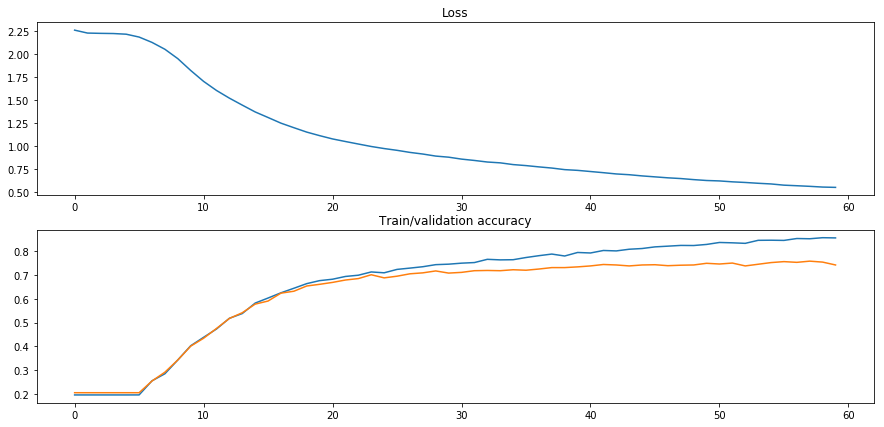

In [20]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [21]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.723000
